In [1]:
import copy
from functools import partial
import gc
from tensorflow import keras
from matplotlib import pyplot as plt
import numpy as np
from uncertainty_testbed.generators.data_generator_explicit import AnalyticBinaryClassGenerator
from uncertainty_testbed.utilities.functions import map_to_constant
from uncertainty_testbed.uncertainty_models.mc_dropout import MCDropoutLayer, MCDropoutKerasClassification

2022-05-08 10:52:16.720899: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-08 10:52:16.720957: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# generate some data
s = partial(map_to_constant, c=0.1)
eg = AnalyticBinaryClassGenerator(seed=42, num_inputs=10, name="gauss", threshold=0.5,
                                  noise_distribution="gauss", noise_scale=s)
x, y = eg.generate_labeled(120096)
x = x.astype("float32")
y = y.astype("uint8")
x_train, y_train = x[:9984, :], y[:9984]
x_val, y_val = x[100096:, :], y[100096:]

In [3]:
def opt_name(optimizer):
    return str(optimizer).split("object")[0].split(".")[-1].strip().lower()

optimizer_lookup = {
    opt_name(opt): opt for opt in  
    [keras.optimizers.Nadam(learning_rate=3e-5), 
     keras.optimizers.SGD(learning_rate=5e-3), 
     keras.optimizers.RMSprop(learning_rate=5e-3),
     keras.optimizers.Adam(learning_rate=3e-3),
     keras.optimizers.Adadelta(learning_rate=1e-1),
     keras.optimizers.Adamax(learning_rate=7e-3)]
}

optimal_schedules = [
    {
        "optimizer": keras.optimizers.Nadam(learning_rate=3e-5),
        "learning_rate": 3e-5,
        "batch": 256,
        "epoch": 10*28
    },
    {
        "optimizer": keras.optimizers.SGD(learning_rate=5e-3),
        "learning_rate": 5e-3,
        "batch": 256,
        "epoch": 10*59
    },
    {
        "optimizer": keras.optimizers.SGD(learning_rate=1e-2),
        "learning_rate" :1e-2,
        "batch": 8,
        "epoch": 10*1
    },
    {
        "optimizer": keras.optimizers.RMSprop(learning_rate=5e-3),
        "learning_rate": 5e-3,
        "batch": 8,
        "epoch": 10*1# 0.1781
    },
    {
        "optimizer": keras.optimizers.Adam(learning_rate=3e-3),
        "learning_rate": 3e-3,
        "batch": 8,
        "epoch": 10*1# 0.2076
    },
    {
        "optimizer": keras.optimizers.Adadelta(learning_rate=1e-1),
        "learning_rate": 1e-1,
        "batch": 8,
        "epoch": 10*2# 0.2354
    },
    {
        "optimizer": keras.optimizers.Adamax(learning_rate=7e-3),
        "learning_rate": 7e-3,
        "batch": 8,
        "epoch": 10*1# 0.2249
    },
    {
        "optimizer": keras.optimizers.Nadam(learning_rate=7e-3),
        "learning_rate": 7e-3,
        "batch": 8,
        "epoch": 10*4# 0.1905
    }
]

In [4]:
scan_results = []
champion_params = None
champion_loss = np.inf
for params in optimal_schedules:
    lr = params["learning_rate"]
    for learning_rate in [0.8*lr, lr, 1.2*lr]:
        optimizer = params["optimizer"]
        optimizer.learning_rate.assign(learning_rate)
        num_epochs = int(1.4*params["epoch"] + 2)
        batch_size = int(params["batch"])
        model = keras.Sequential()
        model.add(keras.layers.Dense(30, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(30, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(30, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(1, activation="sigmoid"))
        model.compile(
            optimizer=optimizer,
            loss="binary_crossentropy",
            metrics=["accuracy", "AUC"]
        )
        history = model.fit(
            x_train,
            y_train,
            epochs=num_epochs,
            batch_size=batch_size,
            validation_data=(x_val, y_val),
        )
        
        history_dict = history.history
        val_loss = history_dict["val_loss"]
        val_auc = history_dict["val_auc"]
        val_accuracy = history_dict["val_accuracy"]
        epochs = range(1, len(val_loss)+1)
        
        best_loss = {"loss": val_loss[np.argmin(val_loss)], "epoch": epochs[np.argmin(val_loss)]}
        best_auc = {"auc": val_auc[np.argmax(val_auc)], "epoch": epochs[np.argmax(val_auc)]}
        best_accuracy = {"accuracy": val_accuracy[np.argmax(val_accuracy)], "epoch": epochs[np.argmax(val_accuracy)]}
        
        ps = {k: copy.deepcopy(v) for k, v in params.items() if k not in ["optimizer", "model"]}
        ps["optimizer"] = opt_name(optimizer)
        ps["learning_rate"] = copy.deepcopy(learning_rate)
        ps["best_loss"] = best_loss
        ps["best_auc"] = best_auc
        ps["best_accuracy"] = best_accuracy
        print(ps)
        scan_results.append(ps)
        
        if best_loss["loss"] < champion_loss:
            champion_loss = best_loss["loss"]
            champion_params = {k: copy.deepcopy(v) for k, v in ps.items()}
            champion_params["model"] = keras.models.clone_model(model)
        

model = keras.models.clone_model(champion_params["model"])

Epoch 1/394


2022-05-08 10:52:20.890859: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-08 10:52:20.890910: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-08 10:52:20.890941: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (xps): /proc/driver/nvidia/version does not exist
2022-05-08 10:52:20.891224: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


39/39 [==============================] - 3s 24ms/step - loss: 0.7103 - accuracy: 0.4844 - auc: 0.4886 - val_loss: 0.6955 - val_accuracy: 0.4816 - val_auc: 0.4948
Epoch 2/394
39/39 [==============================] - 0s 13ms/step - loss: 0.7100 - accuracy: 0.4847 - auc: 0.4878 - val_loss: 0.6922 - val_accuracy: 0.5072 - val_auc: 0.5241
Epoch 3/394
39/39 [==============================] - 0s 11ms/step - loss: 0.7042 - accuracy: 0.4904 - auc: 0.5047 - val_loss: 0.6889 - val_accuracy: 0.5314 - val_auc: 0.5538
Epoch 4/394
39/39 [==============================] - 0s 8ms/step - loss: 0.7006 - accuracy: 0.5053 - auc: 0.5196 - val_loss: 0.6858 - val_accuracy: 0.5541 - val_auc: 0.5837
Epoch 5/394
39/39 [==============================] - 0s 7ms/step - loss: 0.6986 - accuracy: 0.5155 - auc: 0.5294 - val_loss: 0.6825 - val_accuracy: 0.5784 - val_auc: 0.6132
Epoch 6/394
39/39 [==============================] - 0s 9ms/step - loss: 0.6953 - accuracy: 0.5193 - auc: 0.5362 - val_loss: 0.6793 - val_accura

39/39 [==============================] - 0s 7ms/step - loss: 0.5228 - accuracy: 0.7775 - auc: 0.8563 - val_loss: 0.4686 - val_accuracy: 0.8852 - val_auc: 0.9591
Epoch 49/394
39/39 [==============================] - 0s 7ms/step - loss: 0.5203 - accuracy: 0.7747 - auc: 0.8556 - val_loss: 0.4618 - val_accuracy: 0.8873 - val_auc: 0.9604
Epoch 50/394
39/39 [==============================] - 0s 9ms/step - loss: 0.5112 - accuracy: 0.7805 - auc: 0.8641 - val_loss: 0.4550 - val_accuracy: 0.8881 - val_auc: 0.9615
Epoch 51/394
39/39 [==============================] - 0s 11ms/step - loss: 0.5090 - accuracy: 0.7803 - auc: 0.8639 - val_loss: 0.4483 - val_accuracy: 0.8892 - val_auc: 0.9626
Epoch 52/394
39/39 [==============================] - 0s 7ms/step - loss: 0.4965 - accuracy: 0.7922 - auc: 0.8761 - val_loss: 0.4413 - val_accuracy: 0.8911 - val_auc: 0.9637
Epoch 53/394
39/39 [==============================] - 0s 6ms/step - loss: 0.4962 - accuracy: 0.7903 - auc: 0.8707 - val_loss: 0.4345 - val_acc

39/39 [==============================] - 0s 9ms/step - loss: 0.3254 - accuracy: 0.8659 - auc: 0.9400 - val_loss: 0.2272 - val_accuracy: 0.9320 - val_auc: 0.9859
Epoch 96/394
39/39 [==============================] - 1s 14ms/step - loss: 0.3183 - accuracy: 0.8713 - auc: 0.9432 - val_loss: 0.2241 - val_accuracy: 0.9325 - val_auc: 0.9862
Epoch 97/394
39/39 [==============================] - 0s 9ms/step - loss: 0.3201 - accuracy: 0.8678 - auc: 0.9420 - val_loss: 0.2215 - val_accuracy: 0.9330 - val_auc: 0.9864
Epoch 98/394
39/39 [==============================] - 0s 13ms/step - loss: 0.3115 - accuracy: 0.8713 - auc: 0.9457 - val_loss: 0.2186 - val_accuracy: 0.9337 - val_auc: 0.9866
Epoch 99/394
39/39 [==============================] - 0s 9ms/step - loss: 0.3120 - accuracy: 0.8705 - auc: 0.9451 - val_loss: 0.2161 - val_accuracy: 0.9342 - val_auc: 0.9868
Epoch 100/394
39/39 [==============================] - 0s 9ms/step - loss: 0.3071 - accuracy: 0.8743 - auc: 0.9473 - val_loss: 0.2134 - val_a

Epoch 142/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2404 - accuracy: 0.8997 - auc: 0.9653 - val_loss: 0.1434 - val_accuracy: 0.9513 - val_auc: 0.9928
Epoch 143/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2443 - accuracy: 0.9002 - auc: 0.9644 - val_loss: 0.1425 - val_accuracy: 0.9513 - val_auc: 0.9929
Epoch 144/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2360 - accuracy: 0.9015 - auc: 0.9666 - val_loss: 0.1415 - val_accuracy: 0.9516 - val_auc: 0.9930
Epoch 145/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2376 - accuracy: 0.9014 - auc: 0.9661 - val_loss: 0.1405 - val_accuracy: 0.9517 - val_auc: 0.9931
Epoch 146/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2342 - accuracy: 0.9032 - auc: 0.9672 - val_loss: 0.1395 - val_accuracy: 0.9524 - val_auc: 0.9932
Epoch 147/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2254 - accuracy: 0.9075 - auc: 0.9697 - val_loss

Epoch 189/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1930 - accuracy: 0.9213 - auc: 0.9774 - val_loss: 0.1079 - val_accuracy: 0.9613 - val_auc: 0.9956
Epoch 190/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2000 - accuracy: 0.9158 - auc: 0.9757 - val_loss: 0.1075 - val_accuracy: 0.9614 - val_auc: 0.9957
Epoch 191/394
39/39 [==============================] - 0s 11ms/step - loss: 0.1920 - accuracy: 0.9187 - auc: 0.9777 - val_loss: 0.1069 - val_accuracy: 0.9617 - val_auc: 0.9957
Epoch 192/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1939 - accuracy: 0.9201 - auc: 0.9771 - val_loss: 0.1063 - val_accuracy: 0.9615 - val_auc: 0.9958
Epoch 193/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2032 - accuracy: 0.9151 - auc: 0.9749 - val_loss: 0.1059 - val_accuracy: 0.9616 - val_auc: 0.9958
Epoch 194/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1924 - accuracy: 0.9213 - auc: 0.9775 - val_los

Epoch 236/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1693 - accuracy: 0.9303 - auc: 0.9826 - val_loss: 0.0885 - val_accuracy: 0.9682 - val_auc: 0.9971
Epoch 237/394
39/39 [==============================] - 1s 13ms/step - loss: 0.1648 - accuracy: 0.9329 - auc: 0.9835 - val_loss: 0.0881 - val_accuracy: 0.9681 - val_auc: 0.9971
Epoch 238/394
39/39 [==============================] - 0s 13ms/step - loss: 0.1658 - accuracy: 0.9340 - auc: 0.9832 - val_loss: 0.0878 - val_accuracy: 0.9684 - val_auc: 0.9971
Epoch 239/394
39/39 [==============================] - 1s 14ms/step - loss: 0.1656 - accuracy: 0.9341 - auc: 0.9833 - val_loss: 0.0874 - val_accuracy: 0.9683 - val_auc: 0.9971
Epoch 240/394
39/39 [==============================] - 0s 9ms/step - loss: 0.1658 - accuracy: 0.9319 - auc: 0.9833 - val_loss: 0.0872 - val_accuracy: 0.9683 - val_auc: 0.9972
Epoch 241/394
39/39 [==============================] - 0s 12ms/step - loss: 0.1620 - accuracy: 0.9323 - auc: 0.9840 - val_

Epoch 283/394
39/39 [==============================] - 0s 6ms/step - loss: 0.1462 - accuracy: 0.9413 - auc: 0.9868 - val_loss: 0.0749 - val_accuracy: 0.9726 - val_auc: 0.9978
Epoch 284/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1419 - accuracy: 0.9446 - auc: 0.9877 - val_loss: 0.0748 - val_accuracy: 0.9726 - val_auc: 0.9978
Epoch 285/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1377 - accuracy: 0.9411 - auc: 0.9886 - val_loss: 0.0745 - val_accuracy: 0.9727 - val_auc: 0.9979
Epoch 286/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1407 - accuracy: 0.9409 - auc: 0.9880 - val_loss: 0.0743 - val_accuracy: 0.9729 - val_auc: 0.9979
Epoch 287/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1407 - accuracy: 0.9450 - auc: 0.9879 - val_loss: 0.0740 - val_accuracy: 0.9728 - val_auc: 0.9979
Epoch 288/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1458 - accuracy: 0.9383 - auc: 0.9871 - val_loss

Epoch 330/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1304 - accuracy: 0.9457 - auc: 0.9895 - val_loss: 0.0662 - val_accuracy: 0.9759 - val_auc: 0.9983
Epoch 331/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1283 - accuracy: 0.9488 - auc: 0.9899 - val_loss: 0.0661 - val_accuracy: 0.9758 - val_auc: 0.9983
Epoch 332/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1262 - accuracy: 0.9494 - auc: 0.9903 - val_loss: 0.0659 - val_accuracy: 0.9758 - val_auc: 0.9983
Epoch 333/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1307 - accuracy: 0.9466 - auc: 0.9896 - val_loss: 0.0658 - val_accuracy: 0.9758 - val_auc: 0.9983
Epoch 334/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1302 - accuracy: 0.9468 - auc: 0.9895 - val_loss: 0.0656 - val_accuracy: 0.9758 - val_auc: 0.9983
Epoch 335/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1258 - accuracy: 0.9485 - auc: 0.9903 - val_loss

Epoch 377/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1144 - accuracy: 0.9536 - auc: 0.9921 - val_loss: 0.0599 - val_accuracy: 0.9778 - val_auc: 0.9985
Epoch 378/394
39/39 [==============================] - 0s 11ms/step - loss: 0.1164 - accuracy: 0.9533 - auc: 0.9918 - val_loss: 0.0598 - val_accuracy: 0.9777 - val_auc: 0.9985
Epoch 379/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1168 - accuracy: 0.9521 - auc: 0.9916 - val_loss: 0.0597 - val_accuracy: 0.9778 - val_auc: 0.9985
Epoch 380/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1179 - accuracy: 0.9536 - auc: 0.9913 - val_loss: 0.0596 - val_accuracy: 0.9778 - val_auc: 0.9985
Epoch 381/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1159 - accuracy: 0.9527 - auc: 0.9918 - val_loss: 0.0595 - val_accuracy: 0.9778 - val_auc: 0.9985
Epoch 382/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1170 - accuracy: 0.9522 - auc: 0.9915 - val_los

39/39 [==============================] - 0s 6ms/step - loss: 0.4227 - accuracy: 0.8236 - auc: 0.9026 - val_loss: 0.3395 - val_accuracy: 0.9048 - val_auc: 0.9709
Epoch 29/394
39/39 [==============================] - 0s 6ms/step - loss: 0.4143 - accuracy: 0.8287 - auc: 0.9078 - val_loss: 0.3314 - val_accuracy: 0.9071 - val_auc: 0.9720
Epoch 30/394
39/39 [==============================] - 0s 7ms/step - loss: 0.4055 - accuracy: 0.8337 - auc: 0.9124 - val_loss: 0.3235 - val_accuracy: 0.9090 - val_auc: 0.9731
Epoch 31/394
39/39 [==============================] - 0s 5ms/step - loss: 0.4010 - accuracy: 0.8283 - auc: 0.9122 - val_loss: 0.3159 - val_accuracy: 0.9113 - val_auc: 0.9742
Epoch 32/394
39/39 [==============================] - 0s 7ms/step - loss: 0.4040 - accuracy: 0.8281 - auc: 0.9074 - val_loss: 0.3091 - val_accuracy: 0.9127 - val_auc: 0.9751
Epoch 33/394
39/39 [==============================] - 0s 6ms/step - loss: 0.3965 - accuracy: 0.8303 - auc: 0.9117 - val_loss: 0.3025 - val_accu

39/39 [==============================] - 0s 7ms/step - loss: 0.2572 - accuracy: 0.8897 - auc: 0.9606 - val_loss: 0.1556 - val_accuracy: 0.9507 - val_auc: 0.9919
Epoch 76/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2576 - accuracy: 0.8914 - auc: 0.9605 - val_loss: 0.1539 - val_accuracy: 0.9512 - val_auc: 0.9921
Epoch 77/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2508 - accuracy: 0.8951 - auc: 0.9628 - val_loss: 0.1523 - val_accuracy: 0.9517 - val_auc: 0.9922
Epoch 78/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2567 - accuracy: 0.8927 - auc: 0.9605 - val_loss: 0.1507 - val_accuracy: 0.9519 - val_auc: 0.9923
Epoch 79/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2482 - accuracy: 0.8961 - auc: 0.9634 - val_loss: 0.1491 - val_accuracy: 0.9519 - val_auc: 0.9925
Epoch 80/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2441 - accuracy: 0.8985 - auc: 0.9648 - val_loss: 0.1475 - val_accu

39/39 [==============================] - 0s 7ms/step - loss: 0.1938 - accuracy: 0.9209 - auc: 0.9771 - val_loss: 0.1064 - val_accuracy: 0.9640 - val_auc: 0.9958
Epoch 123/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1953 - accuracy: 0.9198 - auc: 0.9768 - val_loss: 0.1057 - val_accuracy: 0.9644 - val_auc: 0.9958
Epoch 124/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1879 - accuracy: 0.9221 - auc: 0.9787 - val_loss: 0.1050 - val_accuracy: 0.9645 - val_auc: 0.9959
Epoch 125/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1917 - accuracy: 0.9183 - auc: 0.9777 - val_loss: 0.1043 - val_accuracy: 0.9647 - val_auc: 0.9959
Epoch 126/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1884 - accuracy: 0.9233 - auc: 0.9785 - val_loss: 0.1037 - val_accuracy: 0.9650 - val_auc: 0.9959
Epoch 127/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1869 - accuracy: 0.9239 - auc: 0.9788 - val_loss: 0.1030 - val

Epoch 169/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1565 - accuracy: 0.9357 - auc: 0.9851 - val_loss: 0.0838 - val_accuracy: 0.9713 - val_auc: 0.9972
Epoch 170/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1588 - accuracy: 0.9355 - auc: 0.9845 - val_loss: 0.0835 - val_accuracy: 0.9717 - val_auc: 0.9972
Epoch 171/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1579 - accuracy: 0.9366 - auc: 0.9846 - val_loss: 0.0831 - val_accuracy: 0.9718 - val_auc: 0.9972
Epoch 172/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1512 - accuracy: 0.9392 - auc: 0.9862 - val_loss: 0.0828 - val_accuracy: 0.9718 - val_auc: 0.9973
Epoch 173/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1586 - accuracy: 0.9346 - auc: 0.9846 - val_loss: 0.0825 - val_accuracy: 0.9718 - val_auc: 0.9973
Epoch 174/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1615 - accuracy: 0.9360 - auc: 0.9840 - val_loss

Epoch 216/394
39/39 [==============================] - 0s 8ms/step - loss: 0.1395 - accuracy: 0.9428 - auc: 0.9882 - val_loss: 0.0711 - val_accuracy: 0.9747 - val_auc: 0.9979
Epoch 217/394
39/39 [==============================] - 0s 8ms/step - loss: 0.1305 - accuracy: 0.9476 - auc: 0.9895 - val_loss: 0.0709 - val_accuracy: 0.9751 - val_auc: 0.9979
Epoch 218/394
39/39 [==============================] - 0s 8ms/step - loss: 0.1315 - accuracy: 0.9471 - auc: 0.9892 - val_loss: 0.0706 - val_accuracy: 0.9750 - val_auc: 0.9979
Epoch 219/394
39/39 [==============================] - 0s 8ms/step - loss: 0.1351 - accuracy: 0.9443 - auc: 0.9889 - val_loss: 0.0704 - val_accuracy: 0.9751 - val_auc: 0.9979
Epoch 220/394
39/39 [==============================] - 0s 8ms/step - loss: 0.1362 - accuracy: 0.9438 - auc: 0.9886 - val_loss: 0.0702 - val_accuracy: 0.9750 - val_auc: 0.9979
Epoch 221/394
39/39 [==============================] - 0s 8ms/step - loss: 0.1342 - accuracy: 0.9431 - auc: 0.9890 - val_loss

Epoch 263/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1175 - accuracy: 0.9514 - auc: 0.9916 - val_loss: 0.0627 - val_accuracy: 0.9765 - val_auc: 0.9983
Epoch 264/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1221 - accuracy: 0.9503 - auc: 0.9905 - val_loss: 0.0626 - val_accuracy: 0.9766 - val_auc: 0.9983
Epoch 265/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1216 - accuracy: 0.9505 - auc: 0.9909 - val_loss: 0.0625 - val_accuracy: 0.9766 - val_auc: 0.9983
Epoch 266/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1161 - accuracy: 0.9508 - auc: 0.9919 - val_loss: 0.0624 - val_accuracy: 0.9766 - val_auc: 0.9983
Epoch 267/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1148 - accuracy: 0.9520 - auc: 0.9919 - val_loss: 0.0622 - val_accuracy: 0.9767 - val_auc: 0.9983
Epoch 268/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1181 - accuracy: 0.9526 - auc: 0.9914 - val_loss

Epoch 310/394
39/39 [==============================] - 0s 6ms/step - loss: 0.1038 - accuracy: 0.9574 - auc: 0.9934 - val_loss: 0.0568 - val_accuracy: 0.9784 - val_auc: 0.9985
Epoch 311/394
39/39 [==============================] - 0s 6ms/step - loss: 0.0982 - accuracy: 0.9589 - auc: 0.9940 - val_loss: 0.0566 - val_accuracy: 0.9784 - val_auc: 0.9985
Epoch 312/394
39/39 [==============================] - 0s 6ms/step - loss: 0.1012 - accuracy: 0.9584 - auc: 0.9939 - val_loss: 0.0566 - val_accuracy: 0.9782 - val_auc: 0.9985
Epoch 313/394
39/39 [==============================] - 0s 6ms/step - loss: 0.1046 - accuracy: 0.9572 - auc: 0.9933 - val_loss: 0.0565 - val_accuracy: 0.9783 - val_auc: 0.9985
Epoch 314/394
39/39 [==============================] - 0s 6ms/step - loss: 0.0949 - accuracy: 0.9601 - auc: 0.9947 - val_loss: 0.0564 - val_accuracy: 0.9782 - val_auc: 0.9985
Epoch 315/394
39/39 [==============================] - 0s 7ms/step - loss: 0.0980 - accuracy: 0.9595 - auc: 0.9941 - val_loss

Epoch 357/394
39/39 [==============================] - 0s 6ms/step - loss: 0.0937 - accuracy: 0.9613 - auc: 0.9946 - val_loss: 0.0527 - val_accuracy: 0.9786 - val_auc: 0.9986
Epoch 358/394
39/39 [==============================] - 0s 6ms/step - loss: 0.0928 - accuracy: 0.9617 - auc: 0.9947 - val_loss: 0.0527 - val_accuracy: 0.9786 - val_auc: 0.9986
Epoch 359/394
39/39 [==============================] - 0s 7ms/step - loss: 0.0956 - accuracy: 0.9613 - auc: 0.9945 - val_loss: 0.0526 - val_accuracy: 0.9788 - val_auc: 0.9986
Epoch 360/394
39/39 [==============================] - 0s 6ms/step - loss: 0.0923 - accuracy: 0.9602 - auc: 0.9949 - val_loss: 0.0526 - val_accuracy: 0.9786 - val_auc: 0.9986
Epoch 361/394
39/39 [==============================] - 0s 7ms/step - loss: 0.0876 - accuracy: 0.9628 - auc: 0.9954 - val_loss: 0.0525 - val_accuracy: 0.9786 - val_auc: 0.9986
Epoch 362/394
39/39 [==============================] - 0s 6ms/step - loss: 0.0926 - accuracy: 0.9625 - auc: 0.9948 - val_loss

39/39 [==============================] - 0s 8ms/step - loss: 0.5674 - accuracy: 0.7379 - auc: 0.8188 - val_loss: 0.5251 - val_accuracy: 0.8621 - val_auc: 0.9499
Epoch 9/394
39/39 [==============================] - 0s 8ms/step - loss: 0.5537 - accuracy: 0.7467 - auc: 0.8331 - val_loss: 0.5062 - val_accuracy: 0.8731 - val_auc: 0.9557
Epoch 10/394
39/39 [==============================] - 0s 7ms/step - loss: 0.5371 - accuracy: 0.7642 - auc: 0.8473 - val_loss: 0.4874 - val_accuracy: 0.8816 - val_auc: 0.9603
Epoch 11/394
39/39 [==============================] - 0s 12ms/step - loss: 0.5222 - accuracy: 0.7802 - auc: 0.8594 - val_loss: 0.4692 - val_accuracy: 0.8884 - val_auc: 0.9641
Epoch 12/394
39/39 [==============================] - 0s 7ms/step - loss: 0.5048 - accuracy: 0.7898 - auc: 0.8726 - val_loss: 0.4511 - val_accuracy: 0.8950 - val_auc: 0.9674
Epoch 13/394
39/39 [==============================] - 0s 9ms/step - loss: 0.4937 - accuracy: 0.7926 - auc: 0.8757 - val_loss: 0.4340 - val_accu

39/39 [==============================] - 0s 7ms/step - loss: 0.2309 - accuracy: 0.9037 - auc: 0.9689 - val_loss: 0.1370 - val_accuracy: 0.9621 - val_auc: 0.9952
Epoch 56/394
39/39 [==============================] - 0s 12ms/step - loss: 0.2360 - accuracy: 0.9044 - auc: 0.9668 - val_loss: 0.1351 - val_accuracy: 0.9621 - val_auc: 0.9953
Epoch 57/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2326 - accuracy: 0.9055 - auc: 0.9681 - val_loss: 0.1332 - val_accuracy: 0.9625 - val_auc: 0.9954
Epoch 58/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2298 - accuracy: 0.9049 - auc: 0.9686 - val_loss: 0.1314 - val_accuracy: 0.9628 - val_auc: 0.9955
Epoch 59/394
39/39 [==============================] - 0s 12ms/step - loss: 0.2276 - accuracy: 0.9040 - auc: 0.9691 - val_loss: 0.1296 - val_accuracy: 0.9632 - val_auc: 0.9956
Epoch 60/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2273 - accuracy: 0.9068 - auc: 0.9693 - val_loss: 0.1278 - val_ac

39/39 [==============================] - 0s 7ms/step - loss: 0.1660 - accuracy: 0.9308 - auc: 0.9832 - val_loss: 0.0863 - val_accuracy: 0.9732 - val_auc: 0.9975
Epoch 103/394
39/39 [==============================] - 0s 12ms/step - loss: 0.1655 - accuracy: 0.9326 - auc: 0.9834 - val_loss: 0.0857 - val_accuracy: 0.9735 - val_auc: 0.9976
Epoch 104/394
39/39 [==============================] - 0s 10ms/step - loss: 0.1637 - accuracy: 0.9314 - auc: 0.9838 - val_loss: 0.0852 - val_accuracy: 0.9735 - val_auc: 0.9976
Epoch 105/394
39/39 [==============================] - 0s 8ms/step - loss: 0.1671 - accuracy: 0.9302 - auc: 0.9830 - val_loss: 0.0846 - val_accuracy: 0.9736 - val_auc: 0.9976
Epoch 106/394
39/39 [==============================] - 0s 8ms/step - loss: 0.1628 - accuracy: 0.9357 - auc: 0.9838 - val_loss: 0.0842 - val_accuracy: 0.9736 - val_auc: 0.9976
Epoch 107/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1658 - accuracy: 0.9305 - auc: 0.9834 - val_loss: 0.0837 - v

Epoch 149/394
39/39 [==============================] - 0s 12ms/step - loss: 0.1373 - accuracy: 0.9426 - auc: 0.9885 - val_loss: 0.0689 - val_accuracy: 0.9765 - val_auc: 0.9982
Epoch 150/394
39/39 [==============================] - 0s 12ms/step - loss: 0.1332 - accuracy: 0.9459 - auc: 0.9892 - val_loss: 0.0686 - val_accuracy: 0.9766 - val_auc: 0.9982
Epoch 151/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1358 - accuracy: 0.9445 - auc: 0.9887 - val_loss: 0.0683 - val_accuracy: 0.9768 - val_auc: 0.9982
Epoch 152/394
39/39 [==============================] - 0s 13ms/step - loss: 0.1355 - accuracy: 0.9442 - auc: 0.9888 - val_loss: 0.0681 - val_accuracy: 0.9766 - val_auc: 0.9983
Epoch 153/394
39/39 [==============================] - 0s 12ms/step - loss: 0.1376 - accuracy: 0.9430 - auc: 0.9884 - val_loss: 0.0679 - val_accuracy: 0.9767 - val_auc: 0.9983
Epoch 154/394
39/39 [==============================] - 0s 11ms/step - loss: 0.1297 - accuracy: 0.9479 - auc: 0.9898 - val

Epoch 196/394
39/39 [==============================] - 0s 8ms/step - loss: 0.1125 - accuracy: 0.9547 - auc: 0.9923 - val_loss: 0.0597 - val_accuracy: 0.9776 - val_auc: 0.9985
Epoch 197/394
39/39 [==============================] - 0s 8ms/step - loss: 0.1085 - accuracy: 0.9547 - auc: 0.9929 - val_loss: 0.0594 - val_accuracy: 0.9775 - val_auc: 0.9985
Epoch 198/394
39/39 [==============================] - 0s 6ms/step - loss: 0.1128 - accuracy: 0.9538 - auc: 0.9922 - val_loss: 0.0592 - val_accuracy: 0.9774 - val_auc: 0.9985
Epoch 199/394
39/39 [==============================] - 0s 8ms/step - loss: 0.1132 - accuracy: 0.9524 - auc: 0.9923 - val_loss: 0.0590 - val_accuracy: 0.9776 - val_auc: 0.9985
Epoch 200/394
39/39 [==============================] - 0s 8ms/step - loss: 0.1121 - accuracy: 0.9544 - auc: 0.9923 - val_loss: 0.0588 - val_accuracy: 0.9776 - val_auc: 0.9985
Epoch 201/394
39/39 [==============================] - 0s 8ms/step - loss: 0.1090 - accuracy: 0.9533 - auc: 0.9928 - val_loss

Epoch 243/394
39/39 [==============================] - 0s 7ms/step - loss: 0.0983 - accuracy: 0.9583 - auc: 0.9940 - val_loss: 0.0536 - val_accuracy: 0.9789 - val_auc: 0.9987
Epoch 244/394
39/39 [==============================] - 0s 7ms/step - loss: 0.0984 - accuracy: 0.9588 - auc: 0.9940 - val_loss: 0.0535 - val_accuracy: 0.9789 - val_auc: 0.9987
Epoch 245/394
39/39 [==============================] - 0s 8ms/step - loss: 0.0963 - accuracy: 0.9578 - auc: 0.9944 - val_loss: 0.0534 - val_accuracy: 0.9789 - val_auc: 0.9987
Epoch 246/394
39/39 [==============================] - 0s 7ms/step - loss: 0.0960 - accuracy: 0.9605 - auc: 0.9944 - val_loss: 0.0533 - val_accuracy: 0.9790 - val_auc: 0.9987
Epoch 247/394
39/39 [==============================] - 0s 7ms/step - loss: 0.0930 - accuracy: 0.9632 - auc: 0.9946 - val_loss: 0.0531 - val_accuracy: 0.9790 - val_auc: 0.9987
Epoch 248/394
39/39 [==============================] - 0s 8ms/step - loss: 0.0918 - accuracy: 0.9645 - auc: 0.9949 - val_loss

Epoch 290/394
39/39 [==============================] - 0s 6ms/step - loss: 0.0865 - accuracy: 0.9658 - auc: 0.9954 - val_loss: 0.0498 - val_accuracy: 0.9797 - val_auc: 0.9988
Epoch 291/394
39/39 [==============================] - 0s 7ms/step - loss: 0.0842 - accuracy: 0.9661 - auc: 0.9957 - val_loss: 0.0497 - val_accuracy: 0.9798 - val_auc: 0.9988
Epoch 292/394
39/39 [==============================] - 0s 7ms/step - loss: 0.0875 - accuracy: 0.9640 - auc: 0.9954 - val_loss: 0.0496 - val_accuracy: 0.9801 - val_auc: 0.9988
Epoch 293/394
39/39 [==============================] - 0s 7ms/step - loss: 0.0814 - accuracy: 0.9653 - auc: 0.9960 - val_loss: 0.0494 - val_accuracy: 0.9800 - val_auc: 0.9988
Epoch 294/394
39/39 [==============================] - 0s 7ms/step - loss: 0.0834 - accuracy: 0.9665 - auc: 0.9958 - val_loss: 0.0493 - val_accuracy: 0.9800 - val_auc: 0.9988
Epoch 295/394
39/39 [==============================] - 0s 6ms/step - loss: 0.0885 - accuracy: 0.9639 - auc: 0.9950 - val_loss

Epoch 337/394
39/39 [==============================] - 0s 7ms/step - loss: 0.0752 - accuracy: 0.9697 - auc: 0.9966 - val_loss: 0.0472 - val_accuracy: 0.9805 - val_auc: 0.9988
Epoch 338/394
39/39 [==============================] - 0s 7ms/step - loss: 0.0763 - accuracy: 0.9701 - auc: 0.9963 - val_loss: 0.0472 - val_accuracy: 0.9804 - val_auc: 0.9988
Epoch 339/394
39/39 [==============================] - 0s 7ms/step - loss: 0.0758 - accuracy: 0.9683 - auc: 0.9965 - val_loss: 0.0471 - val_accuracy: 0.9805 - val_auc: 0.9988
Epoch 340/394
39/39 [==============================] - 0s 7ms/step - loss: 0.0768 - accuracy: 0.9684 - auc: 0.9964 - val_loss: 0.0470 - val_accuracy: 0.9807 - val_auc: 0.9988
Epoch 341/394
39/39 [==============================] - 0s 6ms/step - loss: 0.0734 - accuracy: 0.9691 - auc: 0.9968 - val_loss: 0.0469 - val_accuracy: 0.9807 - val_auc: 0.9988
Epoch 342/394
39/39 [==============================] - 0s 7ms/step - loss: 0.0786 - accuracy: 0.9708 - auc: 0.9962 - val_loss

Epoch 384/394
39/39 [==============================] - 0s 7ms/step - loss: 0.0724 - accuracy: 0.9698 - auc: 0.9969 - val_loss: 0.0456 - val_accuracy: 0.9807 - val_auc: 0.9989
Epoch 385/394
39/39 [==============================] - 0s 7ms/step - loss: 0.0696 - accuracy: 0.9717 - auc: 0.9971 - val_loss: 0.0456 - val_accuracy: 0.9807 - val_auc: 0.9989
Epoch 386/394
39/39 [==============================] - 0s 7ms/step - loss: 0.0689 - accuracy: 0.9716 - auc: 0.9971 - val_loss: 0.0456 - val_accuracy: 0.9808 - val_auc: 0.9989
Epoch 387/394
39/39 [==============================] - 0s 7ms/step - loss: 0.0743 - accuracy: 0.9694 - auc: 0.9966 - val_loss: 0.0456 - val_accuracy: 0.9808 - val_auc: 0.9989
Epoch 388/394
39/39 [==============================] - 0s 7ms/step - loss: 0.0689 - accuracy: 0.9720 - auc: 0.9972 - val_loss: 0.0456 - val_accuracy: 0.9805 - val_auc: 0.9989
Epoch 389/394
39/39 [==============================] - 0s 7ms/step - loss: 0.0703 - accuracy: 0.9722 - auc: 0.9969 - val_loss

39/39 [==============================] - 0s 8ms/step - loss: 0.5859 - accuracy: 0.7108 - auc: 0.7804 - val_loss: 0.5466 - val_accuracy: 0.7870 - val_auc: 0.8731
Epoch 36/828
39/39 [==============================] - 0s 12ms/step - loss: 0.5879 - accuracy: 0.7021 - auc: 0.7732 - val_loss: 0.5402 - val_accuracy: 0.7912 - val_auc: 0.8775
Epoch 37/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5721 - accuracy: 0.7236 - auc: 0.7959 - val_loss: 0.5333 - val_accuracy: 0.7954 - val_auc: 0.8820
Epoch 38/828
39/39 [==============================] - 0s 12ms/step - loss: 0.5676 - accuracy: 0.7260 - auc: 0.8001 - val_loss: 0.5263 - val_accuracy: 0.8010 - val_auc: 0.8867
Epoch 39/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5663 - accuracy: 0.7272 - auc: 0.7991 - val_loss: 0.5192 - val_accuracy: 0.8051 - val_auc: 0.8911
Epoch 40/828
39/39 [==============================] - 0s 11ms/step - loss: 0.5616 - accuracy: 0.7264 - auc: 0.8031 - val_loss: 0.5120 - val_a

39/39 [==============================] - 0s 8ms/step - loss: 0.3177 - accuracy: 0.8714 - auc: 0.9419 - val_loss: 0.2112 - val_accuracy: 0.9377 - val_auc: 0.9871
Epoch 83/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3253 - accuracy: 0.8609 - auc: 0.9379 - val_loss: 0.2070 - val_accuracy: 0.9389 - val_auc: 0.9878
Epoch 84/828
39/39 [==============================] - 0s 12ms/step - loss: 0.3114 - accuracy: 0.8697 - auc: 0.9440 - val_loss: 0.2027 - val_accuracy: 0.9397 - val_auc: 0.9883
Epoch 85/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3067 - accuracy: 0.8694 - auc: 0.9461 - val_loss: 0.1986 - val_accuracy: 0.9412 - val_auc: 0.9888
Epoch 86/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3011 - accuracy: 0.8760 - auc: 0.9484 - val_loss: 0.1945 - val_accuracy: 0.9424 - val_auc: 0.9892
Epoch 87/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3007 - accuracy: 0.8775 - auc: 0.9479 - val_loss: 0.1906 - val_acc

Epoch 129/828
39/39 [==============================] - 0s 9ms/step - loss: 0.1900 - accuracy: 0.9230 - auc: 0.9788 - val_loss: 0.0992 - val_accuracy: 0.9694 - val_auc: 0.9970
Epoch 130/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1844 - accuracy: 0.9271 - auc: 0.9803 - val_loss: 0.0980 - val_accuracy: 0.9699 - val_auc: 0.9971
Epoch 131/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1880 - accuracy: 0.9242 - auc: 0.9793 - val_loss: 0.0969 - val_accuracy: 0.9700 - val_auc: 0.9971
Epoch 132/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1798 - accuracy: 0.9296 - auc: 0.9811 - val_loss: 0.0958 - val_accuracy: 0.9703 - val_auc: 0.9972
Epoch 133/828
39/39 [==============================] - 0s 11ms/step - loss: 0.1831 - accuracy: 0.9267 - auc: 0.9804 - val_loss: 0.0947 - val_accuracy: 0.9701 - val_auc: 0.9972
Epoch 134/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1794 - accuracy: 0.9296 - auc: 0.9812 - val_los

Epoch 176/828
39/39 [==============================] - 0s 10ms/step - loss: 0.1352 - accuracy: 0.9463 - auc: 0.9890 - val_loss: 0.0659 - val_accuracy: 0.9770 - val_auc: 0.9984
Epoch 177/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1262 - accuracy: 0.9515 - auc: 0.9906 - val_loss: 0.0655 - val_accuracy: 0.9772 - val_auc: 0.9984
Epoch 178/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1329 - accuracy: 0.9486 - auc: 0.9895 - val_loss: 0.0652 - val_accuracy: 0.9771 - val_auc: 0.9984
Epoch 179/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1267 - accuracy: 0.9514 - auc: 0.9907 - val_loss: 0.0648 - val_accuracy: 0.9771 - val_auc: 0.9984
Epoch 180/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1297 - accuracy: 0.9502 - auc: 0.9899 - val_loss: 0.0644 - val_accuracy: 0.9772 - val_auc: 0.9984
Epoch 181/828
39/39 [==============================] - 0s 10ms/step - loss: 0.1282 - accuracy: 0.9503 - auc: 0.9901 - val_lo

Epoch 223/828
39/39 [==============================] - 0s 6ms/step - loss: 0.1059 - accuracy: 0.9580 - auc: 0.9933 - val_loss: 0.0538 - val_accuracy: 0.9794 - val_auc: 0.9987
Epoch 224/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1054 - accuracy: 0.9586 - auc: 0.9934 - val_loss: 0.0537 - val_accuracy: 0.9793 - val_auc: 0.9987
Epoch 225/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1027 - accuracy: 0.9608 - auc: 0.9938 - val_loss: 0.0535 - val_accuracy: 0.9793 - val_auc: 0.9987
Epoch 226/828
39/39 [==============================] - 0s 9ms/step - loss: 0.1036 - accuracy: 0.9576 - auc: 0.9936 - val_loss: 0.0534 - val_accuracy: 0.9793 - val_auc: 0.9987
Epoch 227/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1078 - accuracy: 0.9577 - auc: 0.9929 - val_loss: 0.0533 - val_accuracy: 0.9792 - val_auc: 0.9987
Epoch 228/828
39/39 [==============================] - 0s 11ms/step - loss: 0.1053 - accuracy: 0.9585 - auc: 0.9933 - val_los

Epoch 270/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0886 - accuracy: 0.9641 - auc: 0.9954 - val_loss: 0.0481 - val_accuracy: 0.9808 - val_auc: 0.9988
Epoch 271/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0851 - accuracy: 0.9679 - auc: 0.9956 - val_loss: 0.0480 - val_accuracy: 0.9808 - val_auc: 0.9989
Epoch 272/828
39/39 [==============================] - 0s 12ms/step - loss: 0.0920 - accuracy: 0.9634 - auc: 0.9949 - val_loss: 0.0479 - val_accuracy: 0.9809 - val_auc: 0.9989
Epoch 273/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0931 - accuracy: 0.9625 - auc: 0.9946 - val_loss: 0.0478 - val_accuracy: 0.9809 - val_auc: 0.9989
Epoch 274/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0832 - accuracy: 0.9690 - auc: 0.9958 - val_loss: 0.0478 - val_accuracy: 0.9809 - val_auc: 0.9989
Epoch 275/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0838 - accuracy: 0.9672 - auc: 0.9959 - val_los

Epoch 317/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0797 - accuracy: 0.9703 - auc: 0.9962 - val_loss: 0.0452 - val_accuracy: 0.9811 - val_auc: 0.9989
Epoch 318/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0794 - accuracy: 0.9689 - auc: 0.9962 - val_loss: 0.0451 - val_accuracy: 0.9812 - val_auc: 0.9989
Epoch 319/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0782 - accuracy: 0.9696 - auc: 0.9962 - val_loss: 0.0451 - val_accuracy: 0.9811 - val_auc: 0.9989
Epoch 320/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0749 - accuracy: 0.9711 - auc: 0.9967 - val_loss: 0.0451 - val_accuracy: 0.9811 - val_auc: 0.9989
Epoch 321/828
39/39 [==============================] - 0s 12ms/step - loss: 0.0760 - accuracy: 0.9709 - auc: 0.9966 - val_loss: 0.0450 - val_accuracy: 0.9812 - val_auc: 0.9989
Epoch 322/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0822 - accuracy: 0.9684 - auc: 0.9958 - val_los

Epoch 364/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0699 - accuracy: 0.9743 - auc: 0.9969 - val_loss: 0.0438 - val_accuracy: 0.9812 - val_auc: 0.9990
Epoch 365/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0716 - accuracy: 0.9733 - auc: 0.9969 - val_loss: 0.0437 - val_accuracy: 0.9814 - val_auc: 0.9990
Epoch 366/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0705 - accuracy: 0.9741 - auc: 0.9969 - val_loss: 0.0437 - val_accuracy: 0.9815 - val_auc: 0.9990
Epoch 367/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0689 - accuracy: 0.9751 - auc: 0.9969 - val_loss: 0.0437 - val_accuracy: 0.9812 - val_auc: 0.9990
Epoch 368/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0728 - accuracy: 0.9729 - auc: 0.9967 - val_loss: 0.0438 - val_accuracy: 0.9811 - val_auc: 0.9990
Epoch 369/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0688 - accuracy: 0.9720 - auc: 0.9972 - val_loss

Epoch 411/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0630 - accuracy: 0.9767 - auc: 0.9974 - val_loss: 0.0434 - val_accuracy: 0.9812 - val_auc: 0.9990
Epoch 412/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0655 - accuracy: 0.9751 - auc: 0.9973 - val_loss: 0.0434 - val_accuracy: 0.9809 - val_auc: 0.9990
Epoch 413/828
39/39 [==============================] - 0s 12ms/step - loss: 0.0641 - accuracy: 0.9775 - auc: 0.9974 - val_loss: 0.0434 - val_accuracy: 0.9811 - val_auc: 0.9990
Epoch 414/828
39/39 [==============================] - 0s 11ms/step - loss: 0.0643 - accuracy: 0.9748 - auc: 0.9975 - val_loss: 0.0434 - val_accuracy: 0.9810 - val_auc: 0.9990
Epoch 415/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0616 - accuracy: 0.9769 - auc: 0.9977 - val_loss: 0.0434 - val_accuracy: 0.9813 - val_auc: 0.9990
Epoch 416/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0678 - accuracy: 0.9749 - auc: 0.9971 - val_lo

Epoch 458/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0658 - accuracy: 0.9737 - auc: 0.9974 - val_loss: 0.0433 - val_accuracy: 0.9811 - val_auc: 0.9990
Epoch 459/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0599 - accuracy: 0.9763 - auc: 0.9978 - val_loss: 0.0433 - val_accuracy: 0.9813 - val_auc: 0.9990
Epoch 460/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0602 - accuracy: 0.9771 - auc: 0.9978 - val_loss: 0.0432 - val_accuracy: 0.9812 - val_auc: 0.9990
Epoch 461/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0593 - accuracy: 0.9775 - auc: 0.9977 - val_loss: 0.0432 - val_accuracy: 0.9811 - val_auc: 0.9990
Epoch 462/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0592 - accuracy: 0.9788 - auc: 0.9978 - val_loss: 0.0432 - val_accuracy: 0.9812 - val_auc: 0.9990
Epoch 463/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0638 - accuracy: 0.9751 - auc: 0.9974 - val_loss

Epoch 505/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0619 - accuracy: 0.9778 - auc: 0.9973 - val_loss: 0.0434 - val_accuracy: 0.9811 - val_auc: 0.9990
Epoch 506/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0594 - accuracy: 0.9785 - auc: 0.9978 - val_loss: 0.0434 - val_accuracy: 0.9811 - val_auc: 0.9990
Epoch 507/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0598 - accuracy: 0.9776 - auc: 0.9976 - val_loss: 0.0434 - val_accuracy: 0.9811 - val_auc: 0.9990
Epoch 508/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0602 - accuracy: 0.9779 - auc: 0.9977 - val_loss: 0.0434 - val_accuracy: 0.9810 - val_auc: 0.9990
Epoch 509/828
39/39 [==============================] - 0s 11ms/step - loss: 0.0607 - accuracy: 0.9770 - auc: 0.9977 - val_loss: 0.0434 - val_accuracy: 0.9811 - val_auc: 0.9990
Epoch 510/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0597 - accuracy: 0.9771 - auc: 0.9977 - val_los

Epoch 552/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0586 - accuracy: 0.9778 - auc: 0.9977 - val_loss: 0.0435 - val_accuracy: 0.9811 - val_auc: 0.9990
Epoch 553/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0573 - accuracy: 0.9787 - auc: 0.9979 - val_loss: 0.0434 - val_accuracy: 0.9809 - val_auc: 0.9990
Epoch 554/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0553 - accuracy: 0.9808 - auc: 0.9981 - val_loss: 0.0434 - val_accuracy: 0.9811 - val_auc: 0.9990
Epoch 555/828
39/39 [==============================] - 0s 12ms/step - loss: 0.0578 - accuracy: 0.9782 - auc: 0.9978 - val_loss: 0.0435 - val_accuracy: 0.9811 - val_auc: 0.9990
Epoch 556/828
39/39 [==============================] - 0s 9ms/step - loss: 0.0560 - accuracy: 0.9798 - auc: 0.9979 - val_loss: 0.0436 - val_accuracy: 0.9811 - val_auc: 0.9990
Epoch 557/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0579 - accuracy: 0.9805 - auc: 0.9977 - val_los

Epoch 599/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0600 - accuracy: 0.9786 - auc: 0.9975 - val_loss: 0.0436 - val_accuracy: 0.9811 - val_auc: 0.9990
Epoch 600/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0557 - accuracy: 0.9801 - auc: 0.9979 - val_loss: 0.0436 - val_accuracy: 0.9811 - val_auc: 0.9990
Epoch 601/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0565 - accuracy: 0.9793 - auc: 0.9980 - val_loss: 0.0436 - val_accuracy: 0.9814 - val_auc: 0.9990
Epoch 602/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0571 - accuracy: 0.9791 - auc: 0.9978 - val_loss: 0.0435 - val_accuracy: 0.9812 - val_auc: 0.9990
Epoch 603/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0574 - accuracy: 0.9775 - auc: 0.9980 - val_loss: 0.0435 - val_accuracy: 0.9811 - val_auc: 0.9990
Epoch 604/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0547 - accuracy: 0.9791 - auc: 0.9982 - val_loss

Epoch 646/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0541 - accuracy: 0.9801 - auc: 0.9981 - val_loss: 0.0438 - val_accuracy: 0.9813 - val_auc: 0.9990
Epoch 647/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0579 - accuracy: 0.9794 - auc: 0.9977 - val_loss: 0.0438 - val_accuracy: 0.9812 - val_auc: 0.9990
Epoch 648/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0572 - accuracy: 0.9785 - auc: 0.9979 - val_loss: 0.0439 - val_accuracy: 0.9812 - val_auc: 0.9990
Epoch 649/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0541 - accuracy: 0.9799 - auc: 0.9982 - val_loss: 0.0439 - val_accuracy: 0.9811 - val_auc: 0.9990
Epoch 650/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0547 - accuracy: 0.9796 - auc: 0.9980 - val_loss: 0.0438 - val_accuracy: 0.9810 - val_auc: 0.9990
Epoch 651/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0524 - accuracy: 0.9805 - auc: 0.9983 - val_loss

Epoch 693/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0533 - accuracy: 0.9798 - auc: 0.9983 - val_loss: 0.0440 - val_accuracy: 0.9812 - val_auc: 0.9990
Epoch 694/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0538 - accuracy: 0.9806 - auc: 0.9981 - val_loss: 0.0441 - val_accuracy: 0.9810 - val_auc: 0.9990
Epoch 695/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0542 - accuracy: 0.9807 - auc: 0.9982 - val_loss: 0.0441 - val_accuracy: 0.9810 - val_auc: 0.9990
Epoch 696/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0529 - accuracy: 0.9799 - auc: 0.9982 - val_loss: 0.0440 - val_accuracy: 0.9812 - val_auc: 0.9990
Epoch 697/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0555 - accuracy: 0.9799 - auc: 0.9979 - val_loss: 0.0441 - val_accuracy: 0.9809 - val_auc: 0.9990
Epoch 698/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0502 - accuracy: 0.9803 - auc: 0.9985 - val_loss

Epoch 740/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0529 - accuracy: 0.9796 - auc: 0.9982 - val_loss: 0.0441 - val_accuracy: 0.9812 - val_auc: 0.9990
Epoch 741/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0532 - accuracy: 0.9801 - auc: 0.9981 - val_loss: 0.0442 - val_accuracy: 0.9813 - val_auc: 0.9990
Epoch 742/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0535 - accuracy: 0.9809 - auc: 0.9979 - val_loss: 0.0441 - val_accuracy: 0.9813 - val_auc: 0.9990
Epoch 743/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0539 - accuracy: 0.9809 - auc: 0.9979 - val_loss: 0.0442 - val_accuracy: 0.9812 - val_auc: 0.9990
Epoch 744/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0515 - accuracy: 0.9807 - auc: 0.9984 - val_loss: 0.0443 - val_accuracy: 0.9812 - val_auc: 0.9990
Epoch 745/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0510 - accuracy: 0.9809 - auc: 0.9983 - val_loss

Epoch 787/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0497 - accuracy: 0.9812 - auc: 0.9984 - val_loss: 0.0443 - val_accuracy: 0.9814 - val_auc: 0.9990
Epoch 788/828
39/39 [==============================] - 0s 13ms/step - loss: 0.0489 - accuracy: 0.9826 - auc: 0.9984 - val_loss: 0.0444 - val_accuracy: 0.9813 - val_auc: 0.9990
Epoch 789/828
39/39 [==============================] - 0s 11ms/step - loss: 0.0515 - accuracy: 0.9807 - auc: 0.9984 - val_loss: 0.0444 - val_accuracy: 0.9811 - val_auc: 0.9990
Epoch 790/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0549 - accuracy: 0.9790 - auc: 0.9981 - val_loss: 0.0444 - val_accuracy: 0.9811 - val_auc: 0.9990
Epoch 791/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0520 - accuracy: 0.9809 - auc: 0.9983 - val_loss: 0.0444 - val_accuracy: 0.9811 - val_auc: 0.9990
Epoch 792/828
39/39 [==============================] - 0s 12ms/step - loss: 0.0533 - accuracy: 0.9801 - auc: 0.9981 - val_l

39/39 [==============================] - 0s 8ms/step - loss: 0.6757 - accuracy: 0.5723 - auc: 0.6026 - val_loss: 0.6619 - val_accuracy: 0.6349 - val_auc: 0.7013
Epoch 5/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6705 - accuracy: 0.5872 - auc: 0.6207 - val_loss: 0.6571 - val_accuracy: 0.6518 - val_auc: 0.7247
Epoch 6/828
39/39 [==============================] - 0s 8ms/step - loss: 0.6666 - accuracy: 0.5949 - auc: 0.6337 - val_loss: 0.6520 - val_accuracy: 0.6677 - val_auc: 0.7477
Epoch 7/828
39/39 [==============================] - 0s 9ms/step - loss: 0.6597 - accuracy: 0.5999 - auc: 0.6507 - val_loss: 0.6466 - val_accuracy: 0.6827 - val_auc: 0.7681
Epoch 8/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6606 - accuracy: 0.6072 - auc: 0.6497 - val_loss: 0.6411 - val_accuracy: 0.6974 - val_auc: 0.7875
Epoch 9/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6531 - accuracy: 0.6134 - auc: 0.6661 - val_loss: 0.6353 - val_accuracy:

39/39 [==============================] - 0s 8ms/step - loss: 0.3099 - accuracy: 0.8753 - auc: 0.9467 - val_loss: 0.1961 - val_accuracy: 0.9520 - val_auc: 0.9924
Epoch 52/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2972 - accuracy: 0.8835 - auc: 0.9523 - val_loss: 0.1895 - val_accuracy: 0.9535 - val_auc: 0.9929
Epoch 53/828
39/39 [==============================] - 0s 11ms/step - loss: 0.2925 - accuracy: 0.8872 - auc: 0.9529 - val_loss: 0.1832 - val_accuracy: 0.9556 - val_auc: 0.9934
Epoch 54/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2861 - accuracy: 0.8893 - auc: 0.9544 - val_loss: 0.1775 - val_accuracy: 0.9567 - val_auc: 0.9939
Epoch 55/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2837 - accuracy: 0.8889 - auc: 0.9546 - val_loss: 0.1720 - val_accuracy: 0.9582 - val_auc: 0.9943
Epoch 56/828
39/39 [==============================] - 0s 12ms/step - loss: 0.2748 - accuracy: 0.8925 - auc: 0.9587 - val_loss: 0.1669 - val_ac

39/39 [==============================] - 0s 8ms/step - loss: 0.1506 - accuracy: 0.9430 - auc: 0.9868 - val_loss: 0.0742 - val_accuracy: 0.9771 - val_auc: 0.9984
Epoch 99/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1509 - accuracy: 0.9421 - auc: 0.9868 - val_loss: 0.0734 - val_accuracy: 0.9773 - val_auc: 0.9984
Epoch 100/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1486 - accuracy: 0.9420 - auc: 0.9869 - val_loss: 0.0727 - val_accuracy: 0.9772 - val_auc: 0.9984
Epoch 101/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1534 - accuracy: 0.9407 - auc: 0.9858 - val_loss: 0.0721 - val_accuracy: 0.9772 - val_auc: 0.9984
Epoch 102/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1486 - accuracy: 0.9440 - auc: 0.9871 - val_loss: 0.0714 - val_accuracy: 0.9773 - val_auc: 0.9985
Epoch 103/828
39/39 [==============================] - 0s 12ms/step - loss: 0.1495 - accuracy: 0.9428 - auc: 0.9866 - val_loss: 0.0707 - val

Epoch 145/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1143 - accuracy: 0.9574 - auc: 0.9919 - val_loss: 0.0545 - val_accuracy: 0.9796 - val_auc: 0.9988
Epoch 146/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1107 - accuracy: 0.9554 - auc: 0.9927 - val_loss: 0.0543 - val_accuracy: 0.9799 - val_auc: 0.9988
Epoch 147/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1090 - accuracy: 0.9577 - auc: 0.9930 - val_loss: 0.0541 - val_accuracy: 0.9799 - val_auc: 0.9988
Epoch 148/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1027 - accuracy: 0.9619 - auc: 0.9936 - val_loss: 0.0539 - val_accuracy: 0.9800 - val_auc: 0.9988
Epoch 149/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1092 - accuracy: 0.9585 - auc: 0.9928 - val_loss: 0.0537 - val_accuracy: 0.9798 - val_auc: 0.9988
Epoch 150/828
39/39 [==============================] - 0s 6ms/step - loss: 0.1078 - accuracy: 0.9569 - auc: 0.9931 - val_loss

Epoch 192/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0880 - accuracy: 0.9662 - auc: 0.9952 - val_loss: 0.0479 - val_accuracy: 0.9805 - val_auc: 0.9989
Epoch 193/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0872 - accuracy: 0.9650 - auc: 0.9955 - val_loss: 0.0478 - val_accuracy: 0.9805 - val_auc: 0.9989
Epoch 194/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0874 - accuracy: 0.9675 - auc: 0.9953 - val_loss: 0.0476 - val_accuracy: 0.9806 - val_auc: 0.9989
Epoch 195/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0895 - accuracy: 0.9666 - auc: 0.9952 - val_loss: 0.0475 - val_accuracy: 0.9806 - val_auc: 0.9989
Epoch 196/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0884 - accuracy: 0.9656 - auc: 0.9952 - val_loss: 0.0474 - val_accuracy: 0.9804 - val_auc: 0.9989
Epoch 197/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0847 - accuracy: 0.9680 - auc: 0.9957 - val_loss

Epoch 239/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0778 - accuracy: 0.9714 - auc: 0.9961 - val_loss: 0.0451 - val_accuracy: 0.9809 - val_auc: 0.9989
Epoch 240/828
39/39 [==============================] - 0s 12ms/step - loss: 0.0747 - accuracy: 0.9708 - auc: 0.9966 - val_loss: 0.0451 - val_accuracy: 0.9810 - val_auc: 0.9989
Epoch 241/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0746 - accuracy: 0.9723 - auc: 0.9967 - val_loss: 0.0450 - val_accuracy: 0.9807 - val_auc: 0.9989
Epoch 242/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0731 - accuracy: 0.9728 - auc: 0.9966 - val_loss: 0.0450 - val_accuracy: 0.9808 - val_auc: 0.9989
Epoch 243/828
39/39 [==============================] - 0s 11ms/step - loss: 0.0731 - accuracy: 0.9739 - auc: 0.9967 - val_loss: 0.0449 - val_accuracy: 0.9809 - val_auc: 0.9989
Epoch 244/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0715 - accuracy: 0.9725 - auc: 0.9968 - val_lo

Epoch 286/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0724 - accuracy: 0.9716 - auc: 0.9965 - val_loss: 0.0442 - val_accuracy: 0.9812 - val_auc: 0.9989
Epoch 287/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0664 - accuracy: 0.9757 - auc: 0.9972 - val_loss: 0.0442 - val_accuracy: 0.9814 - val_auc: 0.9989
Epoch 288/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0698 - accuracy: 0.9728 - auc: 0.9970 - val_loss: 0.0441 - val_accuracy: 0.9811 - val_auc: 0.9989
Epoch 289/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0699 - accuracy: 0.9748 - auc: 0.9968 - val_loss: 0.0440 - val_accuracy: 0.9812 - val_auc: 0.9989
Epoch 290/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0648 - accuracy: 0.9755 - auc: 0.9973 - val_loss: 0.0440 - val_accuracy: 0.9809 - val_auc: 0.9989
Epoch 291/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0694 - accuracy: 0.9729 - auc: 0.9968 - val_loss

Epoch 333/828
39/39 [==============================] - 0s 12ms/step - loss: 0.0629 - accuracy: 0.9773 - auc: 0.9975 - val_loss: 0.0440 - val_accuracy: 0.9815 - val_auc: 0.9989
Epoch 334/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0657 - accuracy: 0.9762 - auc: 0.9971 - val_loss: 0.0440 - val_accuracy: 0.9814 - val_auc: 0.9989
Epoch 335/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0654 - accuracy: 0.9756 - auc: 0.9973 - val_loss: 0.0440 - val_accuracy: 0.9815 - val_auc: 0.9989
Epoch 336/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0644 - accuracy: 0.9757 - auc: 0.9974 - val_loss: 0.0439 - val_accuracy: 0.9815 - val_auc: 0.9989
Epoch 337/828
39/39 [==============================] - 0s 11ms/step - loss: 0.0643 - accuracy: 0.9760 - auc: 0.9973 - val_loss: 0.0440 - val_accuracy: 0.9812 - val_auc: 0.9989
Epoch 338/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0656 - accuracy: 0.9738 - auc: 0.9974 - val_lo

Epoch 380/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0662 - accuracy: 0.9752 - auc: 0.9972 - val_loss: 0.0439 - val_accuracy: 0.9812 - val_auc: 0.9990
Epoch 381/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0626 - accuracy: 0.9776 - auc: 0.9973 - val_loss: 0.0439 - val_accuracy: 0.9812 - val_auc: 0.9990
Epoch 382/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0606 - accuracy: 0.9767 - auc: 0.9977 - val_loss: 0.0440 - val_accuracy: 0.9811 - val_auc: 0.9990
Epoch 383/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0595 - accuracy: 0.9775 - auc: 0.9977 - val_loss: 0.0440 - val_accuracy: 0.9813 - val_auc: 0.9989
Epoch 384/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0604 - accuracy: 0.9767 - auc: 0.9977 - val_loss: 0.0439 - val_accuracy: 0.9810 - val_auc: 0.9990
Epoch 385/828
39/39 [==============================] - 0s 12ms/step - loss: 0.0590 - accuracy: 0.9783 - auc: 0.9978 - val_los

Epoch 427/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0606 - accuracy: 0.9771 - auc: 0.9976 - val_loss: 0.0440 - val_accuracy: 0.9811 - val_auc: 0.9990
Epoch 428/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0590 - accuracy: 0.9784 - auc: 0.9978 - val_loss: 0.0440 - val_accuracy: 0.9812 - val_auc: 0.9990
Epoch 429/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0573 - accuracy: 0.9784 - auc: 0.9977 - val_loss: 0.0440 - val_accuracy: 0.9811 - val_auc: 0.9990
Epoch 430/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0574 - accuracy: 0.9776 - auc: 0.9979 - val_loss: 0.0442 - val_accuracy: 0.9811 - val_auc: 0.9989
Epoch 431/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0563 - accuracy: 0.9791 - auc: 0.9980 - val_loss: 0.0442 - val_accuracy: 0.9811 - val_auc: 0.9989
Epoch 432/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0591 - accuracy: 0.9782 - auc: 0.9978 - val_loss

Epoch 474/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0549 - accuracy: 0.9801 - auc: 0.9981 - val_loss: 0.0444 - val_accuracy: 0.9811 - val_auc: 0.9990
Epoch 475/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0548 - accuracy: 0.9813 - auc: 0.9981 - val_loss: 0.0444 - val_accuracy: 0.9812 - val_auc: 0.9989
Epoch 476/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0544 - accuracy: 0.9796 - auc: 0.9982 - val_loss: 0.0444 - val_accuracy: 0.9811 - val_auc: 0.9989
Epoch 477/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0595 - accuracy: 0.9763 - auc: 0.9977 - val_loss: 0.0444 - val_accuracy: 0.9814 - val_auc: 0.9990
Epoch 478/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0577 - accuracy: 0.9793 - auc: 0.9977 - val_loss: 0.0445 - val_accuracy: 0.9810 - val_auc: 0.9989
Epoch 479/828
39/39 [==============================] - 0s 11ms/step - loss: 0.0563 - accuracy: 0.9783 - auc: 0.9980 - val_los

Epoch 521/828
39/39 [==============================] - 0s 13ms/step - loss: 0.0539 - accuracy: 0.9792 - auc: 0.9982 - val_loss: 0.0445 - val_accuracy: 0.9809 - val_auc: 0.9989
Epoch 522/828
39/39 [==============================] - 0s 12ms/step - loss: 0.0556 - accuracy: 0.9790 - auc: 0.9980 - val_loss: 0.0445 - val_accuracy: 0.9810 - val_auc: 0.9989
Epoch 523/828
39/39 [==============================] - 0s 12ms/step - loss: 0.0544 - accuracy: 0.9801 - auc: 0.9980 - val_loss: 0.0445 - val_accuracy: 0.9810 - val_auc: 0.9989
Epoch 524/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0528 - accuracy: 0.9805 - auc: 0.9983 - val_loss: 0.0445 - val_accuracy: 0.9811 - val_auc: 0.9989
Epoch 525/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0534 - accuracy: 0.9795 - auc: 0.9980 - val_loss: 0.0446 - val_accuracy: 0.9809 - val_auc: 0.9989
Epoch 526/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0572 - accuracy: 0.9805 - auc: 0.9976 - val_l

Epoch 568/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0517 - accuracy: 0.9818 - auc: 0.9982 - val_loss: 0.0447 - val_accuracy: 0.9809 - val_auc: 0.9989
Epoch 569/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0547 - accuracy: 0.9796 - auc: 0.9978 - val_loss: 0.0447 - val_accuracy: 0.9808 - val_auc: 0.9989
Epoch 570/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0550 - accuracy: 0.9794 - auc: 0.9980 - val_loss: 0.0448 - val_accuracy: 0.9810 - val_auc: 0.9989
Epoch 571/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0532 - accuracy: 0.9803 - auc: 0.9981 - val_loss: 0.0447 - val_accuracy: 0.9811 - val_auc: 0.9989
Epoch 572/828
39/39 [==============================] - 0s 11ms/step - loss: 0.0531 - accuracy: 0.9797 - auc: 0.9982 - val_loss: 0.0446 - val_accuracy: 0.9811 - val_auc: 0.9989
Epoch 573/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0533 - accuracy: 0.9799 - auc: 0.9981 - val_los

Epoch 615/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0499 - accuracy: 0.9805 - auc: 0.9984 - val_loss: 0.0445 - val_accuracy: 0.9810 - val_auc: 0.9989
Epoch 616/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0537 - accuracy: 0.9797 - auc: 0.9982 - val_loss: 0.0446 - val_accuracy: 0.9811 - val_auc: 0.9989
Epoch 617/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0491 - accuracy: 0.9814 - auc: 0.9984 - val_loss: 0.0446 - val_accuracy: 0.9812 - val_auc: 0.9989
Epoch 618/828
39/39 [==============================] - 0s 12ms/step - loss: 0.0531 - accuracy: 0.9806 - auc: 0.9982 - val_loss: 0.0446 - val_accuracy: 0.9813 - val_auc: 0.9989
Epoch 619/828
39/39 [==============================] - 0s 12ms/step - loss: 0.0540 - accuracy: 0.9819 - auc: 0.9980 - val_loss: 0.0446 - val_accuracy: 0.9812 - val_auc: 0.9989
Epoch 620/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0537 - accuracy: 0.9807 - auc: 0.9978 - val_lo

Epoch 662/828
39/39 [==============================] - 0s 12ms/step - loss: 0.0494 - accuracy: 0.9811 - auc: 0.9985 - val_loss: 0.0444 - val_accuracy: 0.9813 - val_auc: 0.9990
Epoch 663/828
39/39 [==============================] - 0s 12ms/step - loss: 0.0543 - accuracy: 0.9799 - auc: 0.9980 - val_loss: 0.0443 - val_accuracy: 0.9812 - val_auc: 0.9990
Epoch 664/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0518 - accuracy: 0.9812 - auc: 0.9982 - val_loss: 0.0445 - val_accuracy: 0.9811 - val_auc: 0.9989
Epoch 665/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0536 - accuracy: 0.9797 - auc: 0.9982 - val_loss: 0.0445 - val_accuracy: 0.9810 - val_auc: 0.9989
Epoch 666/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0511 - accuracy: 0.9811 - auc: 0.9983 - val_loss: 0.0444 - val_accuracy: 0.9814 - val_auc: 0.9989
Epoch 667/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0516 - accuracy: 0.9800 - auc: 0.9982 - val_lo

Epoch 709/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0510 - accuracy: 0.9808 - auc: 0.9982 - val_loss: 0.0445 - val_accuracy: 0.9811 - val_auc: 0.9990
Epoch 710/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0488 - accuracy: 0.9817 - auc: 0.9985 - val_loss: 0.0445 - val_accuracy: 0.9810 - val_auc: 0.9990
Epoch 711/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0524 - accuracy: 0.9814 - auc: 0.9982 - val_loss: 0.0444 - val_accuracy: 0.9811 - val_auc: 0.9990
Epoch 712/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0490 - accuracy: 0.9816 - auc: 0.9985 - val_loss: 0.0443 - val_accuracy: 0.9810 - val_auc: 0.9990
Epoch 713/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0503 - accuracy: 0.9804 - auc: 0.9985 - val_loss: 0.0443 - val_accuracy: 0.9810 - val_auc: 0.9990
Epoch 714/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0512 - accuracy: 0.9806 - auc: 0.9982 - val_loss

Epoch 756/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0498 - accuracy: 0.9824 - auc: 0.9983 - val_loss: 0.0444 - val_accuracy: 0.9811 - val_auc: 0.9990
Epoch 757/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0497 - accuracy: 0.9812 - auc: 0.9985 - val_loss: 0.0443 - val_accuracy: 0.9810 - val_auc: 0.9990
Epoch 758/828
39/39 [==============================] - 0s 11ms/step - loss: 0.0502 - accuracy: 0.9805 - auc: 0.9984 - val_loss: 0.0443 - val_accuracy: 0.9809 - val_auc: 0.9990
Epoch 759/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0496 - accuracy: 0.9815 - auc: 0.9982 - val_loss: 0.0443 - val_accuracy: 0.9811 - val_auc: 0.9990
Epoch 760/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0507 - accuracy: 0.9804 - auc: 0.9984 - val_loss: 0.0443 - val_accuracy: 0.9811 - val_auc: 0.9990
Epoch 761/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0491 - accuracy: 0.9811 - auc: 0.9984 - val_los

Epoch 803/828
39/39 [==============================] - 0s 11ms/step - loss: 0.0483 - accuracy: 0.9822 - auc: 0.9983 - val_loss: 0.0442 - val_accuracy: 0.9809 - val_auc: 0.9990
Epoch 804/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0487 - accuracy: 0.9812 - auc: 0.9986 - val_loss: 0.0443 - val_accuracy: 0.9809 - val_auc: 0.9990
Epoch 805/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0465 - accuracy: 0.9820 - auc: 0.9986 - val_loss: 0.0444 - val_accuracy: 0.9809 - val_auc: 0.9989
Epoch 806/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0490 - accuracy: 0.9809 - auc: 0.9984 - val_loss: 0.0444 - val_accuracy: 0.9810 - val_auc: 0.9990
Epoch 807/828
39/39 [==============================] - 0s 12ms/step - loss: 0.0496 - accuracy: 0.9810 - auc: 0.9983 - val_loss: 0.0443 - val_accuracy: 0.9811 - val_auc: 0.9990
Epoch 808/828
39/39 [==============================] - 0s 12ms/step - loss: 0.0508 - accuracy: 0.9812 - auc: 0.9984 - val_l

39/39 [==============================] - 0s 7ms/step - loss: 0.5809 - accuracy: 0.7267 - auc: 0.7911 - val_loss: 0.5454 - val_accuracy: 0.8146 - val_auc: 0.9015
Epoch 21/828
39/39 [==============================] - 0s 12ms/step - loss: 0.5809 - accuracy: 0.7141 - auc: 0.7834 - val_loss: 0.5347 - val_accuracy: 0.8199 - val_auc: 0.9073
Epoch 22/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5682 - accuracy: 0.7277 - auc: 0.8014 - val_loss: 0.5234 - val_accuracy: 0.8260 - val_auc: 0.9131
Epoch 23/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5589 - accuracy: 0.7360 - auc: 0.8093 - val_loss: 0.5116 - val_accuracy: 0.8330 - val_auc: 0.9188
Epoch 24/828
39/39 [==============================] - 0s 11ms/step - loss: 0.5491 - accuracy: 0.7446 - auc: 0.8197 - val_loss: 0.4994 - val_accuracy: 0.8392 - val_auc: 0.9242
Epoch 25/828
39/39 [==============================] - 0s 8ms/step - loss: 0.5399 - accuracy: 0.7530 - auc: 0.8259 - val_loss: 0.4869 - val_ac

39/39 [==============================] - 0s 11ms/step - loss: 0.2101 - accuracy: 0.9132 - auc: 0.9743 - val_loss: 0.1125 - val_accuracy: 0.9706 - val_auc: 0.9972
Epoch 68/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2042 - accuracy: 0.9157 - auc: 0.9759 - val_loss: 0.1100 - val_accuracy: 0.9710 - val_auc: 0.9973
Epoch 69/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1952 - accuracy: 0.9222 - auc: 0.9787 - val_loss: 0.1073 - val_accuracy: 0.9716 - val_auc: 0.9974
Epoch 70/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1917 - accuracy: 0.9254 - auc: 0.9790 - val_loss: 0.1049 - val_accuracy: 0.9722 - val_auc: 0.9975
Epoch 71/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1897 - accuracy: 0.9270 - auc: 0.9791 - val_loss: 0.1028 - val_accuracy: 0.9721 - val_auc: 0.9976
Epoch 72/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1864 - accuracy: 0.9285 - auc: 0.9804 - val_loss: 0.1006 - val_acc

39/39 [==============================] - 0s 7ms/step - loss: 0.1193 - accuracy: 0.9539 - auc: 0.9916 - val_loss: 0.0582 - val_accuracy: 0.9794 - val_auc: 0.9987
Epoch 115/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1141 - accuracy: 0.9586 - auc: 0.9923 - val_loss: 0.0577 - val_accuracy: 0.9796 - val_auc: 0.9988
Epoch 116/828
39/39 [==============================] - 0s 6ms/step - loss: 0.1131 - accuracy: 0.9573 - auc: 0.9924 - val_loss: 0.0572 - val_accuracy: 0.9797 - val_auc: 0.9988
Epoch 117/828
39/39 [==============================] - 0s 6ms/step - loss: 0.1160 - accuracy: 0.9576 - auc: 0.9918 - val_loss: 0.0568 - val_accuracy: 0.9796 - val_auc: 0.9988
Epoch 118/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1170 - accuracy: 0.9561 - auc: 0.9916 - val_loss: 0.0564 - val_accuracy: 0.9798 - val_auc: 0.9988
Epoch 119/828
39/39 [==============================] - 0s 6ms/step - loss: 0.1132 - accuracy: 0.9568 - auc: 0.9925 - val_loss: 0.0561 - val

Epoch 161/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0859 - accuracy: 0.9671 - auc: 0.9955 - val_loss: 0.0474 - val_accuracy: 0.9811 - val_auc: 0.9989
Epoch 162/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0870 - accuracy: 0.9668 - auc: 0.9952 - val_loss: 0.0473 - val_accuracy: 0.9814 - val_auc: 0.9989
Epoch 163/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0885 - accuracy: 0.9657 - auc: 0.9952 - val_loss: 0.0471 - val_accuracy: 0.9814 - val_auc: 0.9989
Epoch 164/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0878 - accuracy: 0.9660 - auc: 0.9954 - val_loss: 0.0471 - val_accuracy: 0.9812 - val_auc: 0.9989
Epoch 165/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0838 - accuracy: 0.9669 - auc: 0.9957 - val_loss: 0.0471 - val_accuracy: 0.9811 - val_auc: 0.9989
Epoch 166/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0868 - accuracy: 0.9677 - auc: 0.9952 - val_loss

Epoch 208/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0776 - accuracy: 0.9728 - auc: 0.9962 - val_loss: 0.0442 - val_accuracy: 0.9817 - val_auc: 0.9990
Epoch 209/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0735 - accuracy: 0.9710 - auc: 0.9968 - val_loss: 0.0441 - val_accuracy: 0.9818 - val_auc: 0.9990
Epoch 210/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0709 - accuracy: 0.9737 - auc: 0.9968 - val_loss: 0.0441 - val_accuracy: 0.9816 - val_auc: 0.9990
Epoch 211/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0754 - accuracy: 0.9724 - auc: 0.9963 - val_loss: 0.0441 - val_accuracy: 0.9818 - val_auc: 0.9990
Epoch 212/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0706 - accuracy: 0.9748 - auc: 0.9970 - val_loss: 0.0440 - val_accuracy: 0.9816 - val_auc: 0.9990
Epoch 213/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0723 - accuracy: 0.9735 - auc: 0.9967 - val_loss

Epoch 255/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0666 - accuracy: 0.9760 - auc: 0.9972 - val_loss: 0.0436 - val_accuracy: 0.9812 - val_auc: 0.9990
Epoch 256/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0685 - accuracy: 0.9735 - auc: 0.9969 - val_loss: 0.0436 - val_accuracy: 0.9815 - val_auc: 0.9990
Epoch 257/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0649 - accuracy: 0.9750 - auc: 0.9973 - val_loss: 0.0435 - val_accuracy: 0.9815 - val_auc: 0.9990
Epoch 258/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0682 - accuracy: 0.9757 - auc: 0.9970 - val_loss: 0.0435 - val_accuracy: 0.9815 - val_auc: 0.9990
Epoch 259/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0617 - accuracy: 0.9768 - auc: 0.9977 - val_loss: 0.0435 - val_accuracy: 0.9815 - val_auc: 0.9990
Epoch 260/828
39/39 [==============================] - 0s 11ms/step - loss: 0.0659 - accuracy: 0.9739 - auc: 0.9973 - val_los

Epoch 302/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0602 - accuracy: 0.9761 - auc: 0.9977 - val_loss: 0.0433 - val_accuracy: 0.9820 - val_auc: 0.9989
Epoch 303/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0606 - accuracy: 0.9762 - auc: 0.9977 - val_loss: 0.0433 - val_accuracy: 0.9815 - val_auc: 0.9989
Epoch 304/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0623 - accuracy: 0.9762 - auc: 0.9974 - val_loss: 0.0432 - val_accuracy: 0.9815 - val_auc: 0.9989
Epoch 305/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0608 - accuracy: 0.9765 - auc: 0.9976 - val_loss: 0.0432 - val_accuracy: 0.9815 - val_auc: 0.9989
Epoch 306/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0597 - accuracy: 0.9779 - auc: 0.9978 - val_loss: 0.0434 - val_accuracy: 0.9816 - val_auc: 0.9989
Epoch 307/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0606 - accuracy: 0.9767 - auc: 0.9977 - val_loss

Epoch 349/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0581 - accuracy: 0.9780 - auc: 0.9978 - val_loss: 0.0434 - val_accuracy: 0.9814 - val_auc: 0.9990
Epoch 350/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0595 - accuracy: 0.9760 - auc: 0.9977 - val_loss: 0.0433 - val_accuracy: 0.9815 - val_auc: 0.9990
Epoch 351/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0569 - accuracy: 0.9786 - auc: 0.9978 - val_loss: 0.0433 - val_accuracy: 0.9816 - val_auc: 0.9990
Epoch 352/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0572 - accuracy: 0.9781 - auc: 0.9980 - val_loss: 0.0435 - val_accuracy: 0.9812 - val_auc: 0.9989
Epoch 353/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0585 - accuracy: 0.9775 - auc: 0.9977 - val_loss: 0.0434 - val_accuracy: 0.9814 - val_auc: 0.9989
Epoch 354/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0581 - accuracy: 0.9789 - auc: 0.9978 - val_loss

Epoch 396/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0561 - accuracy: 0.9792 - auc: 0.9978 - val_loss: 0.0435 - val_accuracy: 0.9812 - val_auc: 0.9990
Epoch 397/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0560 - accuracy: 0.9797 - auc: 0.9979 - val_loss: 0.0436 - val_accuracy: 0.9811 - val_auc: 0.9989
Epoch 398/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0540 - accuracy: 0.9793 - auc: 0.9981 - val_loss: 0.0437 - val_accuracy: 0.9812 - val_auc: 0.9989
Epoch 399/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0550 - accuracy: 0.9792 - auc: 0.9980 - val_loss: 0.0438 - val_accuracy: 0.9810 - val_auc: 0.9989
Epoch 400/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0569 - accuracy: 0.9783 - auc: 0.9979 - val_loss: 0.0437 - val_accuracy: 0.9814 - val_auc: 0.9989
Epoch 401/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0578 - accuracy: 0.9782 - auc: 0.9977 - val_loss

Epoch 443/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0541 - accuracy: 0.9789 - auc: 0.9981 - val_loss: 0.0438 - val_accuracy: 0.9816 - val_auc: 0.9989
Epoch 444/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0526 - accuracy: 0.9803 - auc: 0.9983 - val_loss: 0.0438 - val_accuracy: 0.9814 - val_auc: 0.9989
Epoch 445/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0543 - accuracy: 0.9798 - auc: 0.9981 - val_loss: 0.0438 - val_accuracy: 0.9813 - val_auc: 0.9989
Epoch 446/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0538 - accuracy: 0.9788 - auc: 0.9982 - val_loss: 0.0438 - val_accuracy: 0.9809 - val_auc: 0.9989
Epoch 447/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0586 - accuracy: 0.9777 - auc: 0.9978 - val_loss: 0.0439 - val_accuracy: 0.9811 - val_auc: 0.9989
Epoch 448/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0533 - accuracy: 0.9795 - auc: 0.9982 - val_loss

Epoch 490/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0527 - accuracy: 0.9803 - auc: 0.9983 - val_loss: 0.0440 - val_accuracy: 0.9812 - val_auc: 0.9989
Epoch 491/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0513 - accuracy: 0.9810 - auc: 0.9982 - val_loss: 0.0441 - val_accuracy: 0.9812 - val_auc: 0.9989
Epoch 492/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0508 - accuracy: 0.9809 - auc: 0.9983 - val_loss: 0.0440 - val_accuracy: 0.9815 - val_auc: 0.9989
Epoch 493/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0532 - accuracy: 0.9796 - auc: 0.9983 - val_loss: 0.0441 - val_accuracy: 0.9814 - val_auc: 0.9989
Epoch 494/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0527 - accuracy: 0.9791 - auc: 0.9982 - val_loss: 0.0442 - val_accuracy: 0.9813 - val_auc: 0.9989
Epoch 495/828
39/39 [==============================] - 0s 5ms/step - loss: 0.0527 - accuracy: 0.9795 - auc: 0.9981 - val_loss

Epoch 537/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0506 - accuracy: 0.9815 - auc: 0.9981 - val_loss: 0.0439 - val_accuracy: 0.9814 - val_auc: 0.9989
Epoch 538/828
39/39 [==============================] - 0s 12ms/step - loss: 0.0535 - accuracy: 0.9810 - auc: 0.9980 - val_loss: 0.0440 - val_accuracy: 0.9814 - val_auc: 0.9989
Epoch 539/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0531 - accuracy: 0.9805 - auc: 0.9981 - val_loss: 0.0440 - val_accuracy: 0.9812 - val_auc: 0.9989
Epoch 540/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0527 - accuracy: 0.9801 - auc: 0.9981 - val_loss: 0.0440 - val_accuracy: 0.9811 - val_auc: 0.9989
Epoch 541/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0500 - accuracy: 0.9832 - auc: 0.9982 - val_loss: 0.0440 - val_accuracy: 0.9811 - val_auc: 0.9989
Epoch 542/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0517 - accuracy: 0.9804 - auc: 0.9982 - val_los

Epoch 584/828
39/39 [==============================] - 0s 9ms/step - loss: 0.0486 - accuracy: 0.9814 - auc: 0.9985 - val_loss: 0.0442 - val_accuracy: 0.9809 - val_auc: 0.9989
Epoch 585/828
39/39 [==============================] - 0s 12ms/step - loss: 0.0501 - accuracy: 0.9809 - auc: 0.9984 - val_loss: 0.0442 - val_accuracy: 0.9809 - val_auc: 0.9989
Epoch 586/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0514 - accuracy: 0.9792 - auc: 0.9980 - val_loss: 0.0442 - val_accuracy: 0.9811 - val_auc: 0.9989
Epoch 587/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0486 - accuracy: 0.9821 - auc: 0.9985 - val_loss: 0.0441 - val_accuracy: 0.9808 - val_auc: 0.9989
Epoch 588/828
39/39 [==============================] - 0s 12ms/step - loss: 0.0492 - accuracy: 0.9817 - auc: 0.9984 - val_loss: 0.0441 - val_accuracy: 0.9808 - val_auc: 0.9989
Epoch 589/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0482 - accuracy: 0.9815 - auc: 0.9985 - val_lo

Epoch 631/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0480 - accuracy: 0.9822 - auc: 0.9986 - val_loss: 0.0443 - val_accuracy: 0.9811 - val_auc: 0.9989
Epoch 632/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0506 - accuracy: 0.9810 - auc: 0.9984 - val_loss: 0.0443 - val_accuracy: 0.9809 - val_auc: 0.9989
Epoch 633/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0508 - accuracy: 0.9800 - auc: 0.9984 - val_loss: 0.0443 - val_accuracy: 0.9811 - val_auc: 0.9989
Epoch 634/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0503 - accuracy: 0.9815 - auc: 0.9984 - val_loss: 0.0443 - val_accuracy: 0.9811 - val_auc: 0.9989
Epoch 635/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0484 - accuracy: 0.9819 - auc: 0.9986 - val_loss: 0.0442 - val_accuracy: 0.9811 - val_auc: 0.9989
Epoch 636/828
39/39 [==============================] - 0s 13ms/step - loss: 0.0509 - accuracy: 0.9806 - auc: 0.9983 - val_los

Epoch 678/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0487 - accuracy: 0.9807 - auc: 0.9985 - val_loss: 0.0442 - val_accuracy: 0.9814 - val_auc: 0.9989
Epoch 679/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0492 - accuracy: 0.9822 - auc: 0.9984 - val_loss: 0.0441 - val_accuracy: 0.9815 - val_auc: 0.9989
Epoch 680/828
39/39 [==============================] - 0s 12ms/step - loss: 0.0474 - accuracy: 0.9829 - auc: 0.9985 - val_loss: 0.0442 - val_accuracy: 0.9813 - val_auc: 0.9989
Epoch 681/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0491 - accuracy: 0.9826 - auc: 0.9984 - val_loss: 0.0441 - val_accuracy: 0.9814 - val_auc: 0.9989
Epoch 682/828
39/39 [==============================] - 0s 12ms/step - loss: 0.0500 - accuracy: 0.9810 - auc: 0.9983 - val_loss: 0.0441 - val_accuracy: 0.9813 - val_auc: 0.9989
Epoch 683/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0475 - accuracy: 0.9821 - auc: 0.9986 - val_lo

Epoch 725/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0479 - accuracy: 0.9812 - auc: 0.9986 - val_loss: 0.0442 - val_accuracy: 0.9815 - val_auc: 0.9989
Epoch 726/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0502 - accuracy: 0.9808 - auc: 0.9984 - val_loss: 0.0441 - val_accuracy: 0.9814 - val_auc: 0.9989
Epoch 727/828
39/39 [==============================] - 0s 9ms/step - loss: 0.0470 - accuracy: 0.9817 - auc: 0.9986 - val_loss: 0.0441 - val_accuracy: 0.9815 - val_auc: 0.9989
Epoch 728/828
39/39 [==============================] - 0s 12ms/step - loss: 0.0482 - accuracy: 0.9808 - auc: 0.9985 - val_loss: 0.0441 - val_accuracy: 0.9815 - val_auc: 0.9989
Epoch 729/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0480 - accuracy: 0.9825 - auc: 0.9986 - val_loss: 0.0442 - val_accuracy: 0.9815 - val_auc: 0.9989
Epoch 730/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0476 - accuracy: 0.9806 - auc: 0.9986 - val_los

Epoch 772/828
39/39 [==============================] - 0s 12ms/step - loss: 0.0483 - accuracy: 0.9819 - auc: 0.9985 - val_loss: 0.0441 - val_accuracy: 0.9818 - val_auc: 0.9989
Epoch 773/828
39/39 [==============================] - 0s 12ms/step - loss: 0.0477 - accuracy: 0.9811 - auc: 0.9984 - val_loss: 0.0441 - val_accuracy: 0.9819 - val_auc: 0.9989
Epoch 774/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0464 - accuracy: 0.9828 - auc: 0.9987 - val_loss: 0.0442 - val_accuracy: 0.9816 - val_auc: 0.9989
Epoch 775/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0465 - accuracy: 0.9814 - auc: 0.9987 - val_loss: 0.0442 - val_accuracy: 0.9815 - val_auc: 0.9989
Epoch 776/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0484 - accuracy: 0.9814 - auc: 0.9985 - val_loss: 0.0444 - val_accuracy: 0.9815 - val_auc: 0.9989
Epoch 777/828
39/39 [==============================] - 0s 12ms/step - loss: 0.0486 - accuracy: 0.9811 - auc: 0.9985 - val_l

Epoch 819/828
39/39 [==============================] - 0s 12ms/step - loss: 0.0460 - accuracy: 0.9814 - auc: 0.9987 - val_loss: 0.0441 - val_accuracy: 0.9816 - val_auc: 0.9989
Epoch 820/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0459 - accuracy: 0.9818 - auc: 0.9987 - val_loss: 0.0441 - val_accuracy: 0.9816 - val_auc: 0.9989
Epoch 821/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0477 - accuracy: 0.9818 - auc: 0.9986 - val_loss: 0.0441 - val_accuracy: 0.9816 - val_auc: 0.9989
Epoch 822/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0462 - accuracy: 0.9833 - auc: 0.9987 - val_loss: 0.0442 - val_accuracy: 0.9815 - val_auc: 0.9989
Epoch 823/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0441 - accuracy: 0.9835 - auc: 0.9988 - val_loss: 0.0443 - val_accuracy: 0.9817 - val_auc: 0.9989
Epoch 824/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0477 - accuracy: 0.9812 - auc: 0.9986 - val_los

1248/1248 [==============================] - 10s 7ms/step - loss: 0.4209 - accuracy: 0.7916 - auc: 0.8888 - val_loss: 0.1070 - val_accuracy: 0.9722 - val_auc: 0.9974
Epoch 2/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.1471 - accuracy: 0.9461 - auc: 0.9873 - val_loss: 0.0579 - val_accuracy: 0.9783 - val_auc: 0.9986
Epoch 3/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.0986 - accuracy: 0.9616 - auc: 0.9941 - val_loss: 0.0492 - val_accuracy: 0.9797 - val_auc: 0.9988
Epoch 4/16
1248/1248 [==============================] - 8s 7ms/step - loss: 0.0851 - accuracy: 0.9692 - auc: 0.9954 - val_loss: 0.0514 - val_accuracy: 0.9780 - val_auc: 0.9987
Epoch 5/16
1248/1248 [==============================] - 6s 5ms/step - loss: 0.0766 - accuracy: 0.9717 - auc: 0.9962 - val_loss: 0.0495 - val_accuracy: 0.9798 - val_auc: 0.9987
Epoch 6/16
1248/1248 [==============================] - 7s 6ms/step - loss: 0.0697 - accuracy: 0.9736 - auc: 0.9968 - val_loss: 0.

Epoch 13/16
1248/1248 [==============================] - 6s 5ms/step - loss: 0.0789 - accuracy: 0.9730 - auc: 0.9955 - val_loss: 0.0589 - val_accuracy: 0.9770 - val_auc: 0.9972
Epoch 14/16
1248/1248 [==============================] - 8s 7ms/step - loss: 0.0849 - accuracy: 0.9745 - auc: 0.9947 - val_loss: 0.0580 - val_accuracy: 0.9776 - val_auc: 0.9975
Epoch 15/16
1248/1248 [==============================] - 8s 7ms/step - loss: 0.0844 - accuracy: 0.9758 - auc: 0.9946 - val_loss: 0.0539 - val_accuracy: 0.9788 - val_auc: 0.9979
Epoch 16/16
1248/1248 [==============================] - 7s 6ms/step - loss: 0.0817 - accuracy: 0.9763 - auc: 0.9946 - val_loss: 0.0760 - val_accuracy: 0.9773 - val_auc: 0.9947
{'learning_rate': 0.005, 'batch': 8, 'epoch': 10, 'optimizer': 'rmsprop', 'best_loss': {'loss': 0.0492248460650444, 'epoch': 10}, 'best_auc': {'auc': 0.9982663989067078, 'epoch': 10}, 'best_accuracy': {'accuracy': 0.9796500205993652, 'epoch': 9}}
Epoch 1/16
1248/1248 [=======================

1248/1248 [==============================] - 9s 7ms/step - loss: 0.0546 - accuracy: 0.9777 - auc: 0.9979 - val_loss: 0.0470 - val_accuracy: 0.9774 - val_auc: 0.9986
Epoch 8/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.0559 - accuracy: 0.9768 - auc: 0.9976 - val_loss: 0.0553 - val_accuracy: 0.9768 - val_auc: 0.9982
Epoch 9/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.0536 - accuracy: 0.9774 - auc: 0.9981 - val_loss: 0.0467 - val_accuracy: 0.9801 - val_auc: 0.9983
Epoch 10/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.0546 - accuracy: 0.9773 - auc: 0.9980 - val_loss: 0.0456 - val_accuracy: 0.9798 - val_auc: 0.9985
Epoch 11/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.0537 - accuracy: 0.9777 - auc: 0.9979 - val_loss: 0.0478 - val_accuracy: 0.9793 - val_auc: 0.9984
Epoch 12/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.0511 - accuracy: 0.9782 - auc: 0.9980 - val_loss: 

Epoch 19/30
1248/1248 [==============================] - 6s 5ms/step - loss: 0.1378 - accuracy: 0.9420 - auc: 0.9883 - val_loss: 0.0633 - val_accuracy: 0.9756 - val_auc: 0.9981
Epoch 20/30
1248/1248 [==============================] - 8s 6ms/step - loss: 0.1281 - accuracy: 0.9478 - auc: 0.9899 - val_loss: 0.0615 - val_accuracy: 0.9764 - val_auc: 0.9982
Epoch 21/30
1248/1248 [==============================] - 8s 6ms/step - loss: 0.1259 - accuracy: 0.9500 - auc: 0.9899 - val_loss: 0.0600 - val_accuracy: 0.9772 - val_auc: 0.9983
Epoch 22/30
1248/1248 [==============================] - 8s 7ms/step - loss: 0.1184 - accuracy: 0.9499 - auc: 0.9912 - val_loss: 0.0585 - val_accuracy: 0.9773 - val_auc: 0.9983
Epoch 23/30
1248/1248 [==============================] - 8s 7ms/step - loss: 0.1248 - accuracy: 0.9495 - auc: 0.9904 - val_loss: 0.0579 - val_accuracy: 0.9779 - val_auc: 0.9984
Epoch 24/30
1248/1248 [==============================] - 8s 6ms/step - loss: 0.1143 - accuracy: 0.9544 - auc: 0.991

1248/1248 [==============================] - 8s 6ms/step - loss: 0.4248 - accuracy: 0.8156 - auc: 0.8967 - val_loss: 0.2691 - val_accuracy: 0.9116 - val_auc: 0.9752
Epoch 3/30
1248/1248 [==============================] - 8s 6ms/step - loss: 0.3233 - accuracy: 0.8643 - auc: 0.9387 - val_loss: 0.1865 - val_accuracy: 0.9390 - val_auc: 0.9877
Epoch 4/30
1248/1248 [==============================] - 8s 7ms/step - loss: 0.2780 - accuracy: 0.8845 - auc: 0.9531 - val_loss: 0.1503 - val_accuracy: 0.9503 - val_auc: 0.9914
Epoch 5/30
1248/1248 [==============================] - 8s 7ms/step - loss: 0.2413 - accuracy: 0.8981 - auc: 0.9647 - val_loss: 0.1284 - val_accuracy: 0.9548 - val_auc: 0.9935
Epoch 6/30
1248/1248 [==============================] - 1720s 1s/step - loss: 0.2265 - accuracy: 0.9048 - auc: 0.9688 - val_loss: 0.1143 - val_accuracy: 0.9583 - val_auc: 0.9948
Epoch 7/30
1248/1248 [==============================] - 8s 7ms/step - loss: 0.2110 - accuracy: 0.9108 - auc: 0.9730 - val_loss: 0

1248/1248 [==============================] - 8s 5ms/step - loss: 0.2019 - accuracy: 0.9131 - auc: 0.9751 - val_loss: 0.0606 - val_accuracy: 0.9763 - val_auc: 0.9983
Epoch 2/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.0901 - accuracy: 0.9637 - auc: 0.9947 - val_loss: 0.0548 - val_accuracy: 0.9778 - val_auc: 0.9983
Epoch 3/16
1248/1248 [==============================] - 6s 5ms/step - loss: 0.0719 - accuracy: 0.9713 - auc: 0.9967 - val_loss: 0.0492 - val_accuracy: 0.9783 - val_auc: 0.9987
Epoch 4/16
1248/1248 [==============================] - 6s 5ms/step - loss: 0.0612 - accuracy: 0.9759 - auc: 0.9975 - val_loss: 0.0528 - val_accuracy: 0.9773 - val_auc: 0.9986
Epoch 5/16
1248/1248 [==============================] - 6s 5ms/step - loss: 0.0575 - accuracy: 0.9775 - auc: 0.9980 - val_loss: 0.0464 - val_accuracy: 0.9796 - val_auc: 0.9988
Epoch 6/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.0523 - accuracy: 0.9792 - auc: 0.9981 - val_loss: 0.0

Epoch 13/58
1248/1248 [==============================] - 8s 6ms/step - loss: 0.0609 - accuracy: 0.9746 - auc: 0.9974 - val_loss: 0.0460 - val_accuracy: 0.9788 - val_auc: 0.9986
Epoch 14/58
1248/1248 [==============================] - 8s 6ms/step - loss: 0.0557 - accuracy: 0.9774 - auc: 0.9979 - val_loss: 0.0560 - val_accuracy: 0.9773 - val_auc: 0.9978
Epoch 15/58
1248/1248 [==============================] - 8s 6ms/step - loss: 0.0622 - accuracy: 0.9757 - auc: 0.9973 - val_loss: 0.0522 - val_accuracy: 0.9783 - val_auc: 0.9984
Epoch 16/58
1248/1248 [==============================] - 8s 6ms/step - loss: 0.0624 - accuracy: 0.9779 - auc: 0.9970 - val_loss: 0.0498 - val_accuracy: 0.9780 - val_auc: 0.9985
Epoch 17/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.0571 - accuracy: 0.9771 - auc: 0.9976 - val_loss: 0.0535 - val_accuracy: 0.9773 - val_auc: 0.9984
Epoch 18/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.0560 - accuracy: 0.9758 - auc: 0.997

1248/1248 [==============================] - 11s 7ms/step - loss: 0.1253 - accuracy: 0.9495 - auc: 0.9902 - val_loss: 0.0502 - val_accuracy: 0.9779 - val_auc: 0.9985
Epoch 2/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.0685 - accuracy: 0.9734 - auc: 0.9970 - val_loss: 0.0535 - val_accuracy: 0.9770 - val_auc: 0.9981
Epoch 3/58
1248/1248 [==============================] - 8s 6ms/step - loss: 0.0690 - accuracy: 0.9725 - auc: 0.9966 - val_loss: 0.0486 - val_accuracy: 0.9779 - val_auc: 0.9986
Epoch 4/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.0678 - accuracy: 0.9696 - auc: 0.9968 - val_loss: 0.0505 - val_accuracy: 0.9776 - val_auc: 0.9981
Epoch 5/58
1248/1248 [==============================] - 7s 5ms/step - loss: 0.0630 - accuracy: 0.9740 - auc: 0.9970 - val_loss: 0.0526 - val_accuracy: 0.9772 - val_auc: 0.9981
Epoch 6/58
1248/1248 [==============================] - 8s 7ms/step - loss: 0.0673 - accuracy: 0.9720 - auc: 0.9966 - val_loss: 0.

1248/1248 [==============================] - 8s 6ms/step - loss: 0.0610 - accuracy: 0.9780 - auc: 0.9973 - val_loss: 0.0488 - val_accuracy: 0.9789 - val_auc: 0.9981
Epoch 48/58
1248/1248 [==============================] - 6s 5ms/step - loss: 0.0577 - accuracy: 0.9793 - auc: 0.9976 - val_loss: 0.0529 - val_accuracy: 0.9777 - val_auc: 0.9987
Epoch 49/58
1248/1248 [==============================] - 6s 5ms/step - loss: 0.0552 - accuracy: 0.9794 - auc: 0.9978 - val_loss: 0.0602 - val_accuracy: 0.9785 - val_auc: 0.9972
Epoch 50/58
1248/1248 [==============================] - 7s 6ms/step - loss: 0.0546 - accuracy: 0.9771 - auc: 0.9977 - val_loss: 0.0563 - val_accuracy: 0.9775 - val_auc: 0.9973
Epoch 51/58
1248/1248 [==============================] - 7s 6ms/step - loss: 0.0561 - accuracy: 0.9776 - auc: 0.9976 - val_loss: 0.0500 - val_accuracy: 0.9785 - val_auc: 0.9980
Epoch 52/58
1248/1248 [==============================] - 7s 6ms/step - loss: 0.0553 - accuracy: 0.9798 - auc: 0.9977 - val_loss

Epoch 34/58
1248/1248 [==============================] - 8s 7ms/step - loss: 0.0608 - accuracy: 0.9753 - auc: 0.9974 - val_loss: 0.0460 - val_accuracy: 0.9790 - val_auc: 0.9985
Epoch 35/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.0627 - accuracy: 0.9769 - auc: 0.9973 - val_loss: 0.0509 - val_accuracy: 0.9780 - val_auc: 0.9980
Epoch 36/58
1248/1248 [==============================] - 8s 6ms/step - loss: 0.0591 - accuracy: 0.9770 - auc: 0.9973 - val_loss: 0.0543 - val_accuracy: 0.9772 - val_auc: 0.9979
Epoch 37/58
1248/1248 [==============================] - 8s 6ms/step - loss: 0.0618 - accuracy: 0.9764 - auc: 0.9974 - val_loss: 0.0477 - val_accuracy: 0.9785 - val_auc: 0.9983
Epoch 38/58
1248/1248 [==============================] - 8s 6ms/step - loss: 0.0609 - accuracy: 0.9757 - auc: 0.9972 - val_loss: 0.0527 - val_accuracy: 0.9778 - val_auc: 0.9979
Epoch 39/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.0590 - accuracy: 0.9752 - auc: 0.997

In [5]:
optimizer = optimizer_lookup[champion_params["optimizer"]]
learning_rate = champion_params["learning_rate"]
optimizer.learning_rate.assign(learning_rate)
batch_size = champion_params["batch"]
num_epochs = champion_params["best_loss"]["epoch"]

# train a Keras MLP
model = keras.Sequential()
model.add(keras.layers.Dense(30, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(30, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(30, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(1, activation="sigmoid"))
model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy", "AUC"]
)
history = model.fit(
    x_train,
    y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)

Epoch 1/16
1248/1248 [==============================] - 10s 7ms/step - loss: 0.1792 - accuracy: 0.9210 - auc: 0.9801 - val_loss: 0.0599 - val_accuracy: 0.9748 - val_auc: 0.9980
Epoch 2/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.0731 - accuracy: 0.9693 - auc: 0.9966 - val_loss: 0.0477 - val_accuracy: 0.9790 - val_auc: 0.9986
Epoch 3/16
1248/1248 [==============================] - 9s 7ms/step - loss: 0.0650 - accuracy: 0.9743 - auc: 0.9971 - val_loss: 0.0493 - val_accuracy: 0.9787 - val_auc: 0.9986
Epoch 4/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.0621 - accuracy: 0.9763 - auc: 0.9974 - val_loss: 0.0487 - val_accuracy: 0.9793 - val_auc: 0.9985
Epoch 5/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.0563 - accuracy: 0.9749 - auc: 0.9978 - val_loss: 0.0504 - val_accuracy: 0.9773 - val_auc: 0.9985
Epoch 6/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.0580 - accuracy: 0.9762 - auc: 0.9977 - v

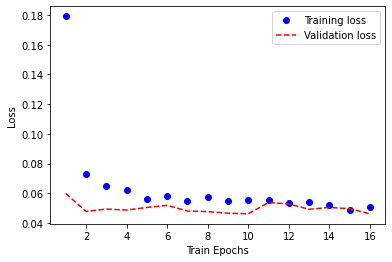

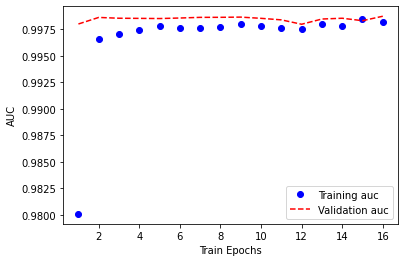

In [6]:
# inspect metrics
history_dict = history.history
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]
auc = history_dict["auc"]
val_auc = history_dict["val_auc"]
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "r--", label="Validation loss")
plt.xlabel("Train Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(epochs, auc, "bo", label="Training auc")
plt.plot(epochs, val_auc, "r--", label="Validation auc")
plt.xlabel("Train Epochs")
plt.ylabel("AUC")
plt.legend()
plt.show()

In [7]:
n = 5
s = 100

p = model.predict(x_val[:1000,:])[:, 0]

scores = eg.get_scores(x_val[:1000,:])
ix_srt = np.argsort(scores)

probs = eg.get_probabilities(x_val[:1000,:])[1]

p = np.convolve(p[ix_srt[::-1]], np.ones(n)/n, mode='valid')
scores = np.convolve(scores[ix_srt[::-1]], np.ones(n)/n, mode='valid')
probs = np.convolve(probs[ix_srt[::-1]], np.ones(n)/n, mode='valid')

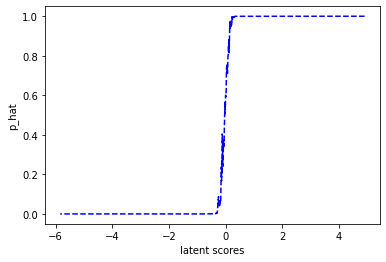

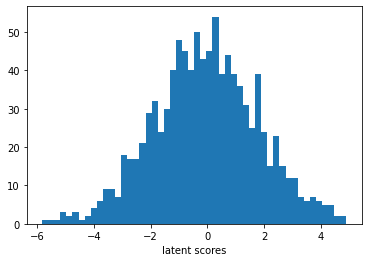

In [8]:
plt.plot(scores, p, '--b')
plt.xlabel('latent scores')
plt.ylabel('p_hat')
plt.show()

plt.hist(scores, bins=50)
plt.xlabel('latent scores')
plt.show()

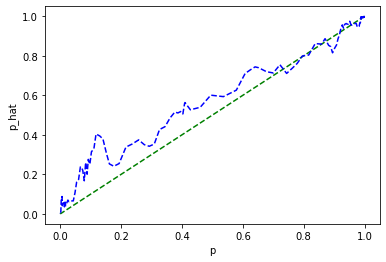

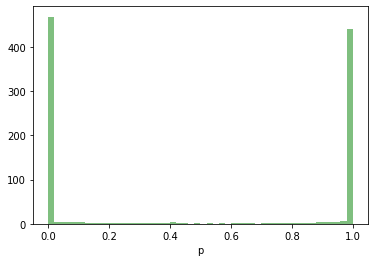

In [9]:
plt.plot(probs, probs, '--g')
plt.plot(probs, p, '--b')
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

plt.hist(probs, bins=50, color='g', alpha=0.5)
plt.xlabel('p')
plt.show()

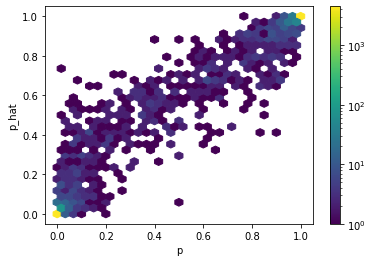

In [10]:
n = 1
s = 100

p = model.predict(x_val[:10000,:])[:, 0]

scores = eg.get_scores(x_val[:10000,:])

probs = eg.get_probabilities(x_val[:10000,:])[1]

plt.hexbin(probs, p, gridsize=30, bins='log')
plt.colorbar()
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

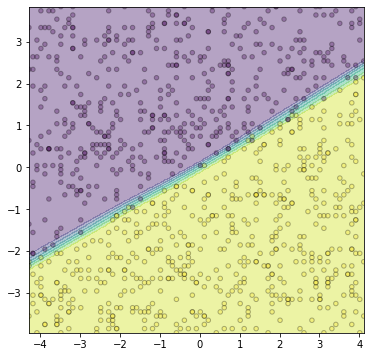

In [11]:
# Plot decision regions
I, J = 2, 6
x_min, x_max = x_val[:, I].min(), x_val[:, I].max()
y_min, y_max = x_val[:, J].min(), x_val[:, J].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
xxyy = np.c_[xx.ravel(), yy.ravel()]
x_ = np.zeros((xxyy.shape[0], 10))
x_[:, I] = xxyy[:, 0]
x_[:, J] = xxyy[:, 1]
z = model.predict(x_)
z = z.reshape(xx.shape)
y_ = eg.get_labels(x_)

fig = plt.figure(figsize=(6,6))
ax = fig.gca()
ax.contourf(xx, yy, z, alpha=0.4)
ixs = np.random.randint(0, y_.shape[0]-1, 1000)
ax.scatter(x_[ixs, I], x_[ixs, J], c=y_[ixs], s=20, alpha=0.3, edgecolor="k")
plt.show()

#model.summary()

In [12]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_96 (Dense)            (None, 30)                330       
                                                                 
 dropout_72 (Dropout)        (None, 30)                0         
                                                                 
 dense_97 (Dense)            (None, 30)                930       
                                                                 
 dropout_73 (Dropout)        (None, 30)                0         
                                                                 
 dense_98 (Dense)            (None, 30)                930       
                                                                 
 dropout_74 (Dropout)        (None, 30)                0         
                                                                 
 dense_99 (Dense)            (None, 1)               

In [13]:
champion_params

{'learning_rate': 0.0024000000000000002,
 'batch': 8,
 'epoch': 10,
 'optimizer': 'adam',
 'best_loss': {'loss': 0.04295552521944046, 'epoch': 16},
 'best_auc': {'auc': 0.998823881149292, 'epoch': 16},
 'best_accuracy': {'accuracy': 0.9800999760627747, 'epoch': 16},
 'model': <keras.engine.sequential.Sequential at 0x7fbb618bbdf0>}

In [14]:
scan_results

[{'learning_rate': 2.4e-05,
  'batch': 256,
  'epoch': 280,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.05819251015782356, 'epoch': 394},
  'best_auc': {'auc': 0.9985508918762207, 'epoch': 393},
  'best_accuracy': {'accuracy': 0.9782500267028809, 'epoch': 391}},
 {'learning_rate': 3e-05,
  'batch': 256,
  'epoch': 280,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.050625141710042953, 'epoch': 394},
  'best_auc': {'auc': 0.9986739158630371, 'epoch': 393},
  'best_accuracy': {'accuracy': 0.9790499806404114, 'epoch': 346}},
 {'learning_rate': 3.6e-05,
  'batch': 256,
  'epoch': 280,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.045470137149095535, 'epoch': 393},
  'best_auc': {'auc': 0.9988802075386047, 'epoch': 389},
  'best_accuracy': {'accuracy': 0.9809499979019165, 'epoch': 369}},
 {'learning_rate': 0.004,
  'batch': 256,
  'epoch': 590,
  'optimizer': 'sgd',
  'best_loss': {'loss': 0.04308956116437912, 'epoch': 427},
  'best_auc': {'auc': 0.9989849925041199, 'epoch': 47

### Tuning notes: 

Data: train 100096 / val 20000

--
* model: 30, 0.25, 30, 0.25, 30, 0.25, 30, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 80/80 **val_loss: 0.4221** - val_accuracy: 0.7657 - val_auc: 0.9857

--
* model: 30, 0.25, 30, 0.25, 30, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 60/80 **val_loss: 0.3241** - val_accuracy: 0.8463 - val_auc: 0.9856

--
* model: 40, 0.25, 40, 0.25, 40, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 40/80 **val_loss: 0.2726** - val_accuracy: 0.8848 - val_auc: 0.9889

--
* model: 50, 0.25, 50, 0.25, 50, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 38/80 **val_loss: 0.2555** - val_accuracy: 0.8832 - val_auc: 0.9916

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 28/80 **val_loss: 0.2552** - val_accuracy: 0.8909 - val_auc: 0.9929

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / Nadam lr: 2e-5
* Epoch: 48/80 **0.2557** - val_accuracy: 0.8771 - val_auc: 0.9935

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 20, 0.25, 6, 0.25, 1/ batch: 256 / Nadam lr: 2e-5
* Epoch: 47/80 **0.3482** - val_accuracy: 0.8346 - val_auc: 0.9910

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / SGD lr: 5e-3
* Epoch: 59/80 **0.2176** - val_accuracy: 0.8953 - val_auc: 0.9961

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / SGD lr: 3e-3
* Epoch: 80/100 **0.2205** - val_accuracy: 0.8970 - val_auc: 0.9951

--
8/1e-2=> 0.2021 - val_accuracy: 0.9207 - val_auc: 0.9904
8/8e-3=> 0.26...
8/1.3e-2=> 0.25